(template_notebook)=
# Bayesian Workflow with SEMs 

:::{post} Novemeber, 2025
:tags: confirmatory factor analysis, structural equation models, 
:category: advanced, reference
:author: Nathaniel Forde
:::

This is some introductory text. Consult the [style guide](https://docs.pymc.io/en/latest/contributing/jupyter_style.html).

In [49]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import pytensor
pytensor.config.cxx = '/usr/bin/clang++'

import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
%config InlineBackend.figure_format = 'retina'  # high resolution figures
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(42)

## Job Satisfaction and Bayesian Workflows

In [5]:

# | code-fold: true

# Standard deviations
stds = np.array([0.939, 1.017, 0.937, 0.562, 0.760, 0.524, 
                 0.585, 0.609, 0.731, 0.711, 1.124, 1.001])

n = len(stds)

# Lower triangular correlation values as a flat list
corr_values = [
    1.000,
    .668, 1.000,
    .635, .599, 1.000,
    .263, .261, .164, 1.000,
    .290, .315, .247, .486, 1.000,
    .207, .245, .231, .251, .449, 1.000,
   -.206, -.182, -.195, -.309, -.266, -.142, 1.000,
   -.280, -.241, -.238, -.344, -.305, -.230,  .753, 1.000,
   -.258, -.244, -.185, -.255, -.255, -.215,  .554,  .587, 1.000,
    .080,  .096,  .094, -.017,  .151,  .141, -.074, -.111,  .016, 1.000,
    .061,  .028, -.035, -.058, -.051, -.003, -.040, -.040, -.018,  .284, 1.000,
    .113,  .174,  .059,  .063,  .138,  .044, -.119, -.073, -.084,  .563,  .379, 1.000
]

# Fill correlation matrix
corr_matrix = np.zeros((n, n))
idx = 0
for i in range(n):
    for j in range(i+1):
        corr_matrix[i, j] = corr_values[idx]
        corr_matrix[j, i] = corr_values[idx]
        idx += 1

# Covariance matrix: Sigma = D * R * D
cov_matrix = np.outer(stds, stds) * corr_matrix
#cov_matrix_test = np.dot(np.dot(np.diag(stds), corr_matrix), np.diag(stds))
FEATURE_COLUMNS=["JW1","JW2","JW3", "UF1","UF2","FOR", "DA1","DA2","DA3", "EBA","ST","MI"]
corr_df = pd.DataFrame(corr_matrix, columns=FEATURE_COLUMNS)

cov_df = pd.DataFrame(cov_matrix, columns=FEATURE_COLUMNS)

def make_sample(cov_matrix, size, columns, missing_frac=0.0, impute=False):
    sample_df = pd.DataFrame(np.random.multivariate_normal([0]*12, cov_matrix, size=size), columns=FEATURE_COLUMNS)
    if missing_frac > 0.0: 
        total_values = sample_df.size
        num_nans = int(total_values * missing_frac)

        # Choose random flat indices
        nan_indices = np.random.choice(total_values, num_nans, replace=False)

        # Convert flat indices to (row, col)
        rows, cols = np.unravel_index(nan_indices, sample_df.shape)

        # Set the values to NaN
        sample_df.values[rows, cols] = np.nan

    if impute: 
        sample_df.fillna(sample_df.mean(axis=0), inplace=True)


    return sample_df

sample_df = make_sample(cov_matrix, 263, FEATURE_COLUMNS)
sample_df.head(10)

JW1       JW2       JW3       UF1       UF2       FOR       DA1  \
0 -0.355264 -0.138567 -0.416267  0.387040 -0.409966 -0.685045  0.551483   
1  3.135523  2.233013  1.686842  0.651217  0.436981  0.068051 -1.125376   
2  0.580981  1.436013  1.418568  0.169118  0.702554  0.352063 -0.847132   
3  2.225250  1.770181  1.448460  0.122075 -0.384125  0.341035 -0.744869   
4 -0.217553  0.362079 -0.174953 -0.019765  1.143683  0.654399 -0.193514   
5 -0.697347 -0.001249 -0.319558  0.363777  0.010874  0.177394 -0.075262   
6  0.372561  0.999235  1.099559  0.087096  0.991282 -0.276627  0.454742   
7  0.435557  0.256463  0.824628  0.182394  0.596904  0.175763 -0.411939   
8 -0.293234 -0.785348 -0.748749 -0.579486 -0.242783 -0.269153 -0.009257   
9  1.650896  0.958802  1.803148 -0.014083  0.295889 -0.430911  0.581749   

        DA2       DA3       EBA        ST        MI  
0  0.773278  0.125668  0.189472  0.939471  0.531176  
1 -1.490458 -1.587940 -1.337920 -0.978484 -0.712167  
2 -0.834597 -0.462754  1.817919  0.337847  1.349882  
3 -1.192972 -0.356887  0.338599 -0.249265 -0.654629  
4 -0.200546 -0.850478  0.741874  0.749728  0.173329  
5  0.337647  0.128512  0.090753 -2.111179  0.543911  
6  0.830033  1.016586  1.786522 -0.286415  2.089513  
7 -0.188678  0.023960  1.556906  0.797298  1.027437  
8  0.259637  0.683575 -0.588188  0.367622 -1.928123  
9  0.101228  0.264995  0.578845  0.923705  1.353942

## Mathematical Interlude

Structural Equation Model (SEM): General Setup

We have observed variables $y \in R^{p}$, here (p=12) and $\eta \in R^{m} latent factors where m=4 and the SEM consists of two parts:

$$ y_i = \Lambda \eta_i + \varepsilon_i, 
\quad \varepsilon_i \sim \mathcal N(0, \Psi).
$$

Measurement model

Structural 

$$
\eta_i = B \eta_i + \zeta_i, 
\quad \zeta_i \sim \mathcal N(0, \Psi_{\zeta}).
$$


$$
\eta_i = (I - B)^{-1} \zeta_i.
$$

### Conditional Formulation

$$
\zeta_i \sim \mathcal N(0, \Psi_{\zeta}).

\\

\eta_i = (I-B)^{-1} \zeta_i.

\\

\mu_i = \Lambda \eta_i.

\\

y_i \mid \eta_i \sim \mathcal MvN(\mu_i, \Psi).

$$

so that 

$$ p(y_i, \zeta_i) = 
\mathcal N\!\left(\zeta_i; 0, \Psi_{\zeta}\right) \cdot
\mathcal N\!\left(y_i;\; \Lambda (I-B)^{-1}\zeta_i, \; \Psi\right).
$$

## Confirmatory Factor Analysis

In [162]:
sample_df = make_sample(cov_matrix, 263, FEATURE_COLUMNS)

coords = {
    "obs": list(range(len(sample_df))),
    "indicators": FEATURE_COLUMNS,
    "indicators_1": ["JW1", "JW2",  "JW3"], # job satisfaction
    "indicators_2": ["UF1", "UF2", "FOR"], # well being
    "indicators_3": ["DA1", "DA2", "DA3"], # dysfunction
    "indicators_4": ["EBA", "ST", "MI"], # constructive thought strategies
    "latent": ["satisfaction", "well being", "dysfunctional", "constructive"],
    "latent1": ["satisfaction", "well being", "dysfunctional", "constructive"],
    "paths": ["dysfunctional ~ constructive", "well being ~ dysfunctional", "well being ~ constructive", "satisfaction ~ well being", "satisfaction ~ dysfunction" ,  "satisfaction ~ constructive"], 
    "sd_params": [i + '_sd' for i in FEATURE_COLUMNS],
    "corr_params": ['UF1 ~~ FOR']
}

def make_lambda(indicators, name='lambdas1', priors=[1, 10]):
    """ Takes an argument indicators which is a string in the coords dict"""
    temp_name = name + '_'
    lambdas_ = pm.Normal(temp_name, priors[0], priors[1], dims=(indicators))
    # Force a fixed scale on the factor loadings for factor 1
    lambdas_1 = pm.Deterministic(
        name, pt.set_subtensor(lambdas_[0], 1), dims=(indicators)
    )
    return lambdas_1

def make_B(priors=[0, .5], group_suffix=''):
    coefs = pm.Normal(f'mu_betas{group_suffix}', [0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1], dims='paths')

    zeros = pt.zeros((4, 4))
    ## dysfunctional ~ constructive
    zeros = pt.set_subtensor(zeros[3, 2], coefs[0])
    ## well being ~ dysfunctional
    zeros = pt.set_subtensor(zeros[2, 1], coefs[1])
    ## well being ~ constructive
    zeros = pt.set_subtensor(zeros[3, 1], coefs[2])
    ## satisfaction ~ well being
    zeros = pt.set_subtensor(zeros[1, 0], coefs[3])
    ## satisfaction ~ dysfunction
    zeros = pt.set_subtensor(zeros[2, 0], coefs[4])
    ## satisfaction ~ constructive
    coefs_ = pt.set_subtensor(zeros[3, 0], coefs[5])
    return coefs_

def make_Psi(indicators, name='Psi_cov'):
    """ Takes an argument indicators which is a string in the coords dict"""
    temp_name = name + '_'
    n = len(coords[indicators])
    cov_params = pm.InverseGamma(temp_name, 3, 4, dims='sd_params')
    r = pt.zeros((n, n))
    beta_params = pm.Beta(temp_name + 'beta', 1, 1, dims='corr_params')
    for i in range(len(coords[indicators])):
        r = pt.set_subtensor(r[i, i], 1)
    # UF1 ~~ FOR
    r = pt.set_subtensor(r[3, 5], beta_params[0])
    s = pt.diag(cov_params)
    cov = (s @ r) @ pt.transpose(s @ r)
    r = pm.Deterministic('Psi_corr', r)
    cov = pm.Deterministic('Psi_cov', cov)

    return cov

def make_ppc(
    idata,
    df,
    samples=100,
    drivers=FEATURE_COLUMNS,
    dims=(2, 3),
):
    fig, axs = plt.subplots(dims[0], dims[1], figsize=(20, 10))
    axs = axs.flatten()
    for i in range(len(drivers)):
        for j in range(samples):
            temp = az.extract(idata["posterior_predictive"].sel({"likelihood_dim_3": i}))[
                "likelihood"
            ].values[:, j]
            temp = pd.DataFrame(temp, columns=["likelihood"])
            if j == 0:
                axs[i].hist(df[drivers[i]], alpha=0.3, ec="black", bins=20, label="Observed Scores")
                axs[i].hist(
                    temp["likelihood"], color="purple", alpha=0.1, bins=20, label="Predicted Scores"
                )
            else:
                axs[i].hist(df[drivers[i]], alpha=0.3, ec="black", bins=20)
                axs[i].hist(temp["likelihood"], color="purple", alpha=0.1, bins=20)
            axs[i].set_title(f"Posterior Predictive Checks {drivers[i]}")
            axs[i].legend()
    plt.tight_layout()
    plt.show()

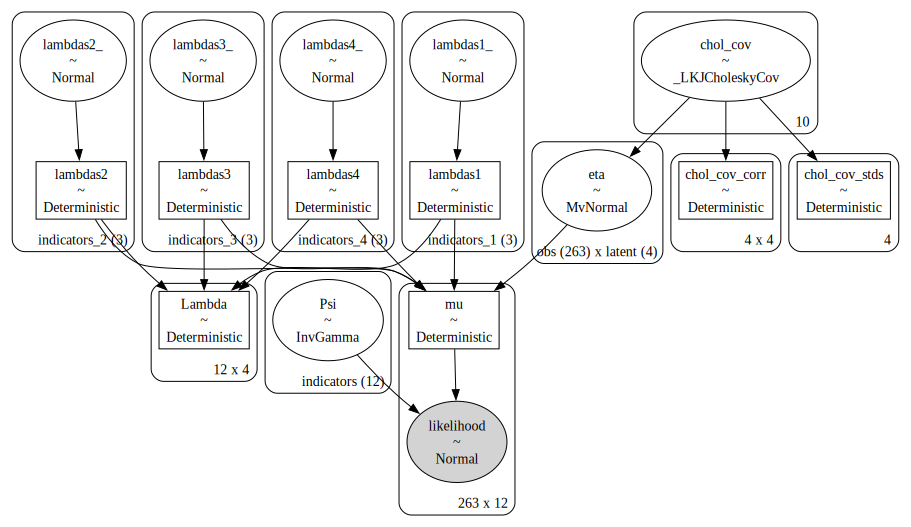

In [101]:
obs_idx = list(range(len(sample_df)))
observed_data = sample_df[coords['indicators']].values
conditional = False

with pm.Model(coords=coords) as cfa_model_v0:
    
    # --- Factor loadings ---
    lambdas_1 = make_lambda('indicators_1', 'lambdas1', priors=[1, .5])
    lambdas_2 = make_lambda('indicators_2', 'lambdas2', priors=[1, .5])
    lambdas_3 = make_lambda('indicators_3', 'lambdas3', priors=[1, .5])
    lambdas_4 = make_lambda('indicators_4', 'lambdas4', priors=[1, .5])

    Lambda = pt.zeros((12, 4))
    Lambda = pt.set_subtensor(Lambda[0:3, 0], lambdas_1)
    Lambda = pt.set_subtensor(Lambda[3:6, 1], lambdas_2)
    Lambda = pt.set_subtensor(Lambda[6:9, 2], lambdas_3)
    Lambda = pt.set_subtensor(Lambda[9:12, 3], lambdas_4)
    Lambda = pm.Deterministic('Lambda', Lambda)

    # --- Latent variables (η) ---
    sd_dist = pm.Exponential.dist(1.0, shape=4)
    chol, _, _ = pm.LKJCholeskyCov("chol_cov", n=4, eta=2, sd_dist=sd_dist, compute_corr=True)
    eta = pm.MvNormal("eta", 0, chol=chol, dims=("obs", "latent"))

    # --- Linear predictor: Λη ---
    m1 = eta[obs_idx, 0] * lambdas_1[0]
    m2 = eta[obs_idx, 0] * lambdas_1[1]
    m3 = eta[obs_idx, 0] * lambdas_1[2]
    m4 = eta[obs_idx, 1] * lambdas_2[0]
    m5 = eta[obs_idx, 1] * lambdas_2[1]
    m6 = eta[obs_idx, 1] * lambdas_2[2]
    m7 = eta[obs_idx, 2] * lambdas_3[0]
    m8 = eta[obs_idx, 2] * lambdas_3[1]
    m9 = eta[obs_idx, 2] * lambdas_3[2]
    m10 = eta[obs_idx, 3] * lambdas_4[0]
    m11 = eta[obs_idx, 3] * lambdas_4[1]
    m12 = eta[obs_idx, 3] * lambdas_4[2]


    mu = pm.Deterministic("mu", pm.math.stack([m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, m12]).T)

    ## Error Terms
    Psi = pm.InverseGamma("Psi", 5, 10, dims="indicators")
    _ = pm.Normal('likelihood', mu=mu, sigma=Psi, observed=observed_data)

pm.model_to_graphviz(cfa_model_v0)

In [102]:
sampler_kwargs = {'draws': 1000}

def sample_model(model, sampler_kwargs):
    with model: 
        idata = pm.sample_prior_predictive()
        idata.extend(pm.sample(**sampler_kwargs, idata_kwargs={"log_likelihood": True}))
        idata.extend(pm.sample_posterior_predictive(idata))
    return idata

idata_cfa_model_v0 = sample_model(cfa_model_v0, sampler_kwargs=sampler_kwargs)

Sampling: [Psi, chol_cov, eta, lambdas1_, lambdas2_, lambdas3_, lambdas4_, likelihood]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambdas1_, lambdas2_, lambdas3_, lambdas4_, chol_cov, eta, Psi]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

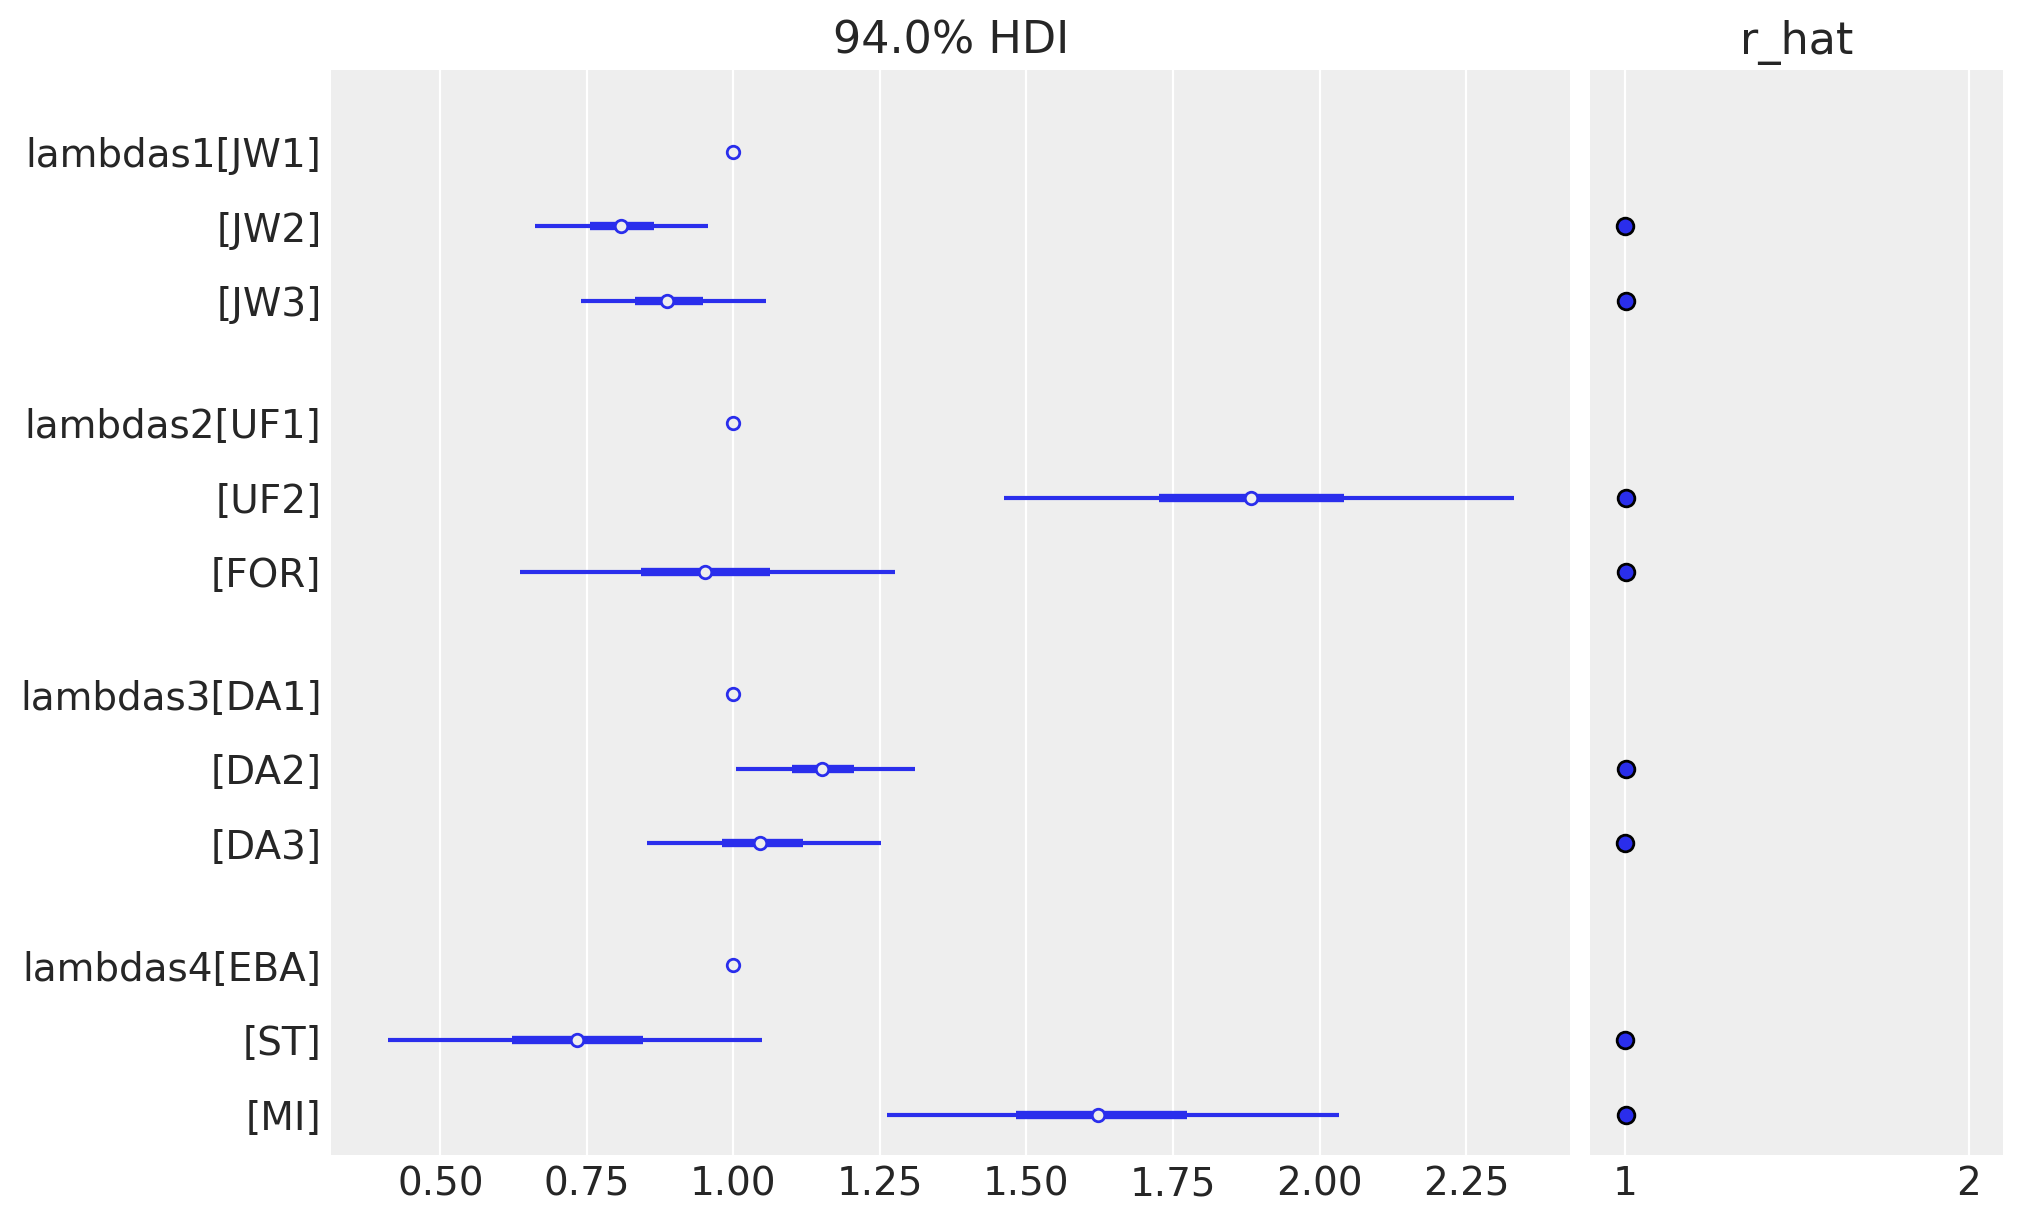

In [103]:
az.plot_forest(idata_cfa_model_v0, var_names=['lambdas1', 'lambdas2', 'lambdas3', 'lambdas4'], combined=True, figsize=(10, 6), r_hat=True);

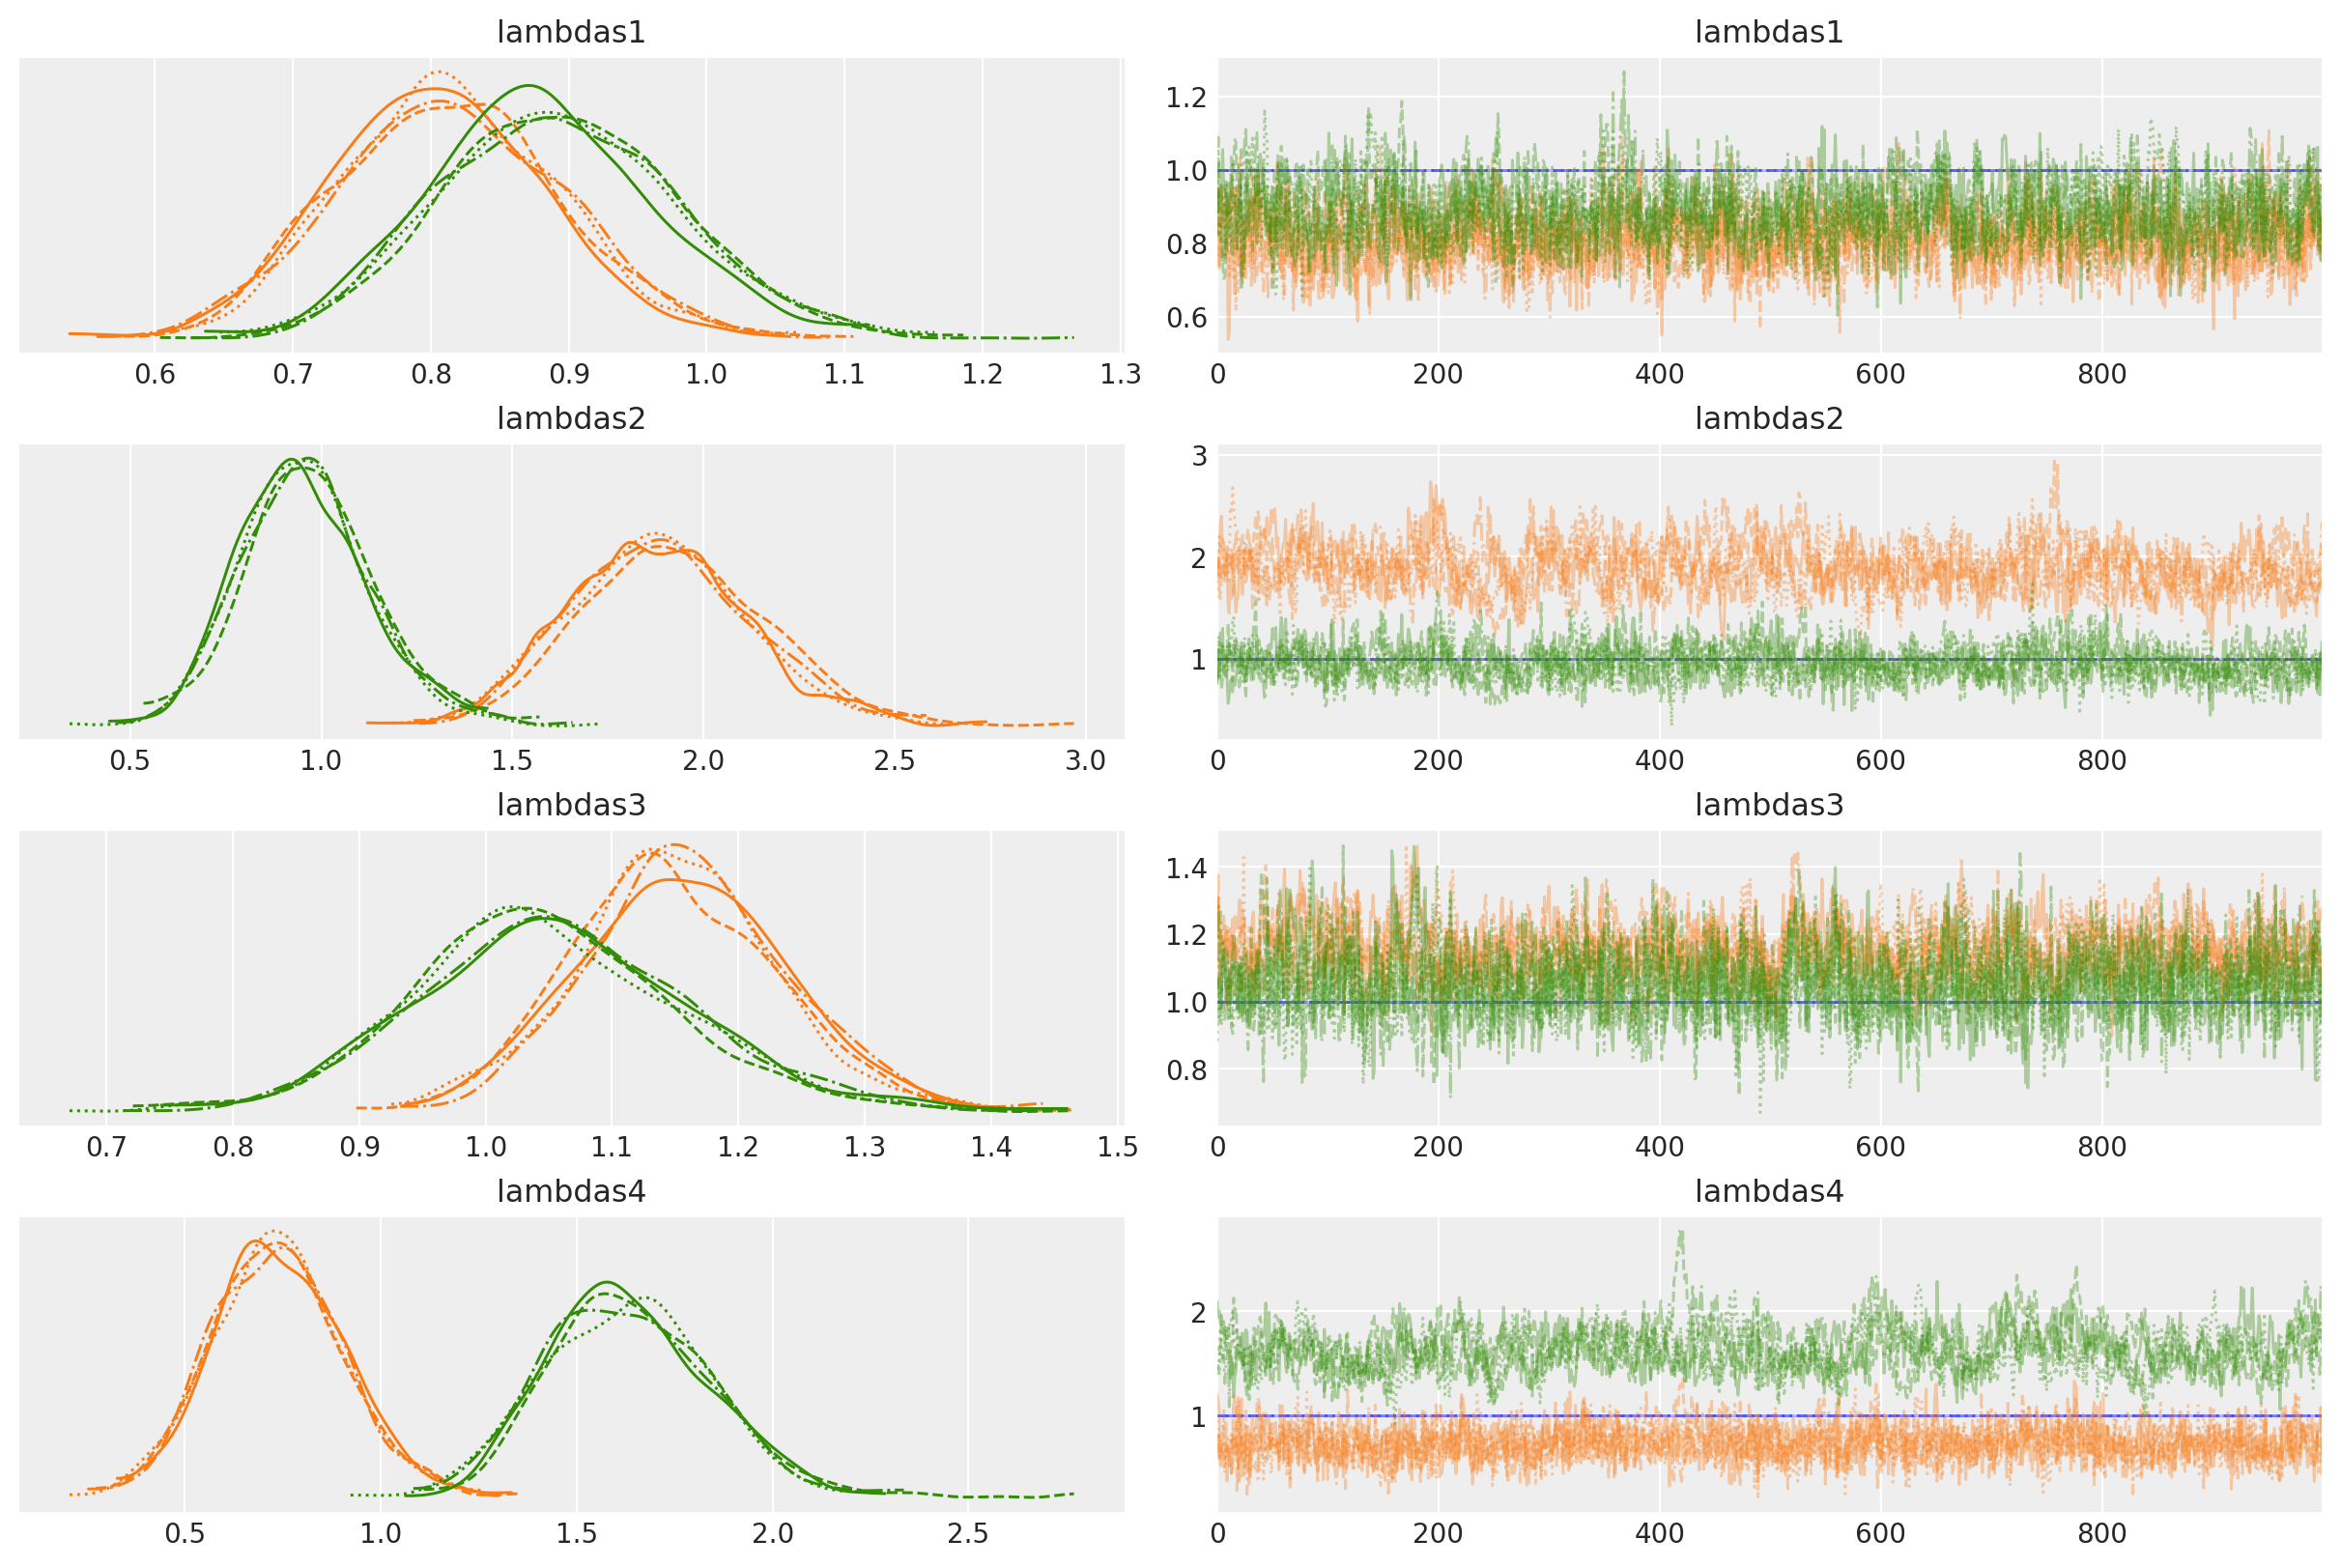

In [104]:
az.plot_trace(idata_cfa_model_v0, var_names=['lambdas1', 'lambdas2', 'lambdas3', 'lambdas4']);

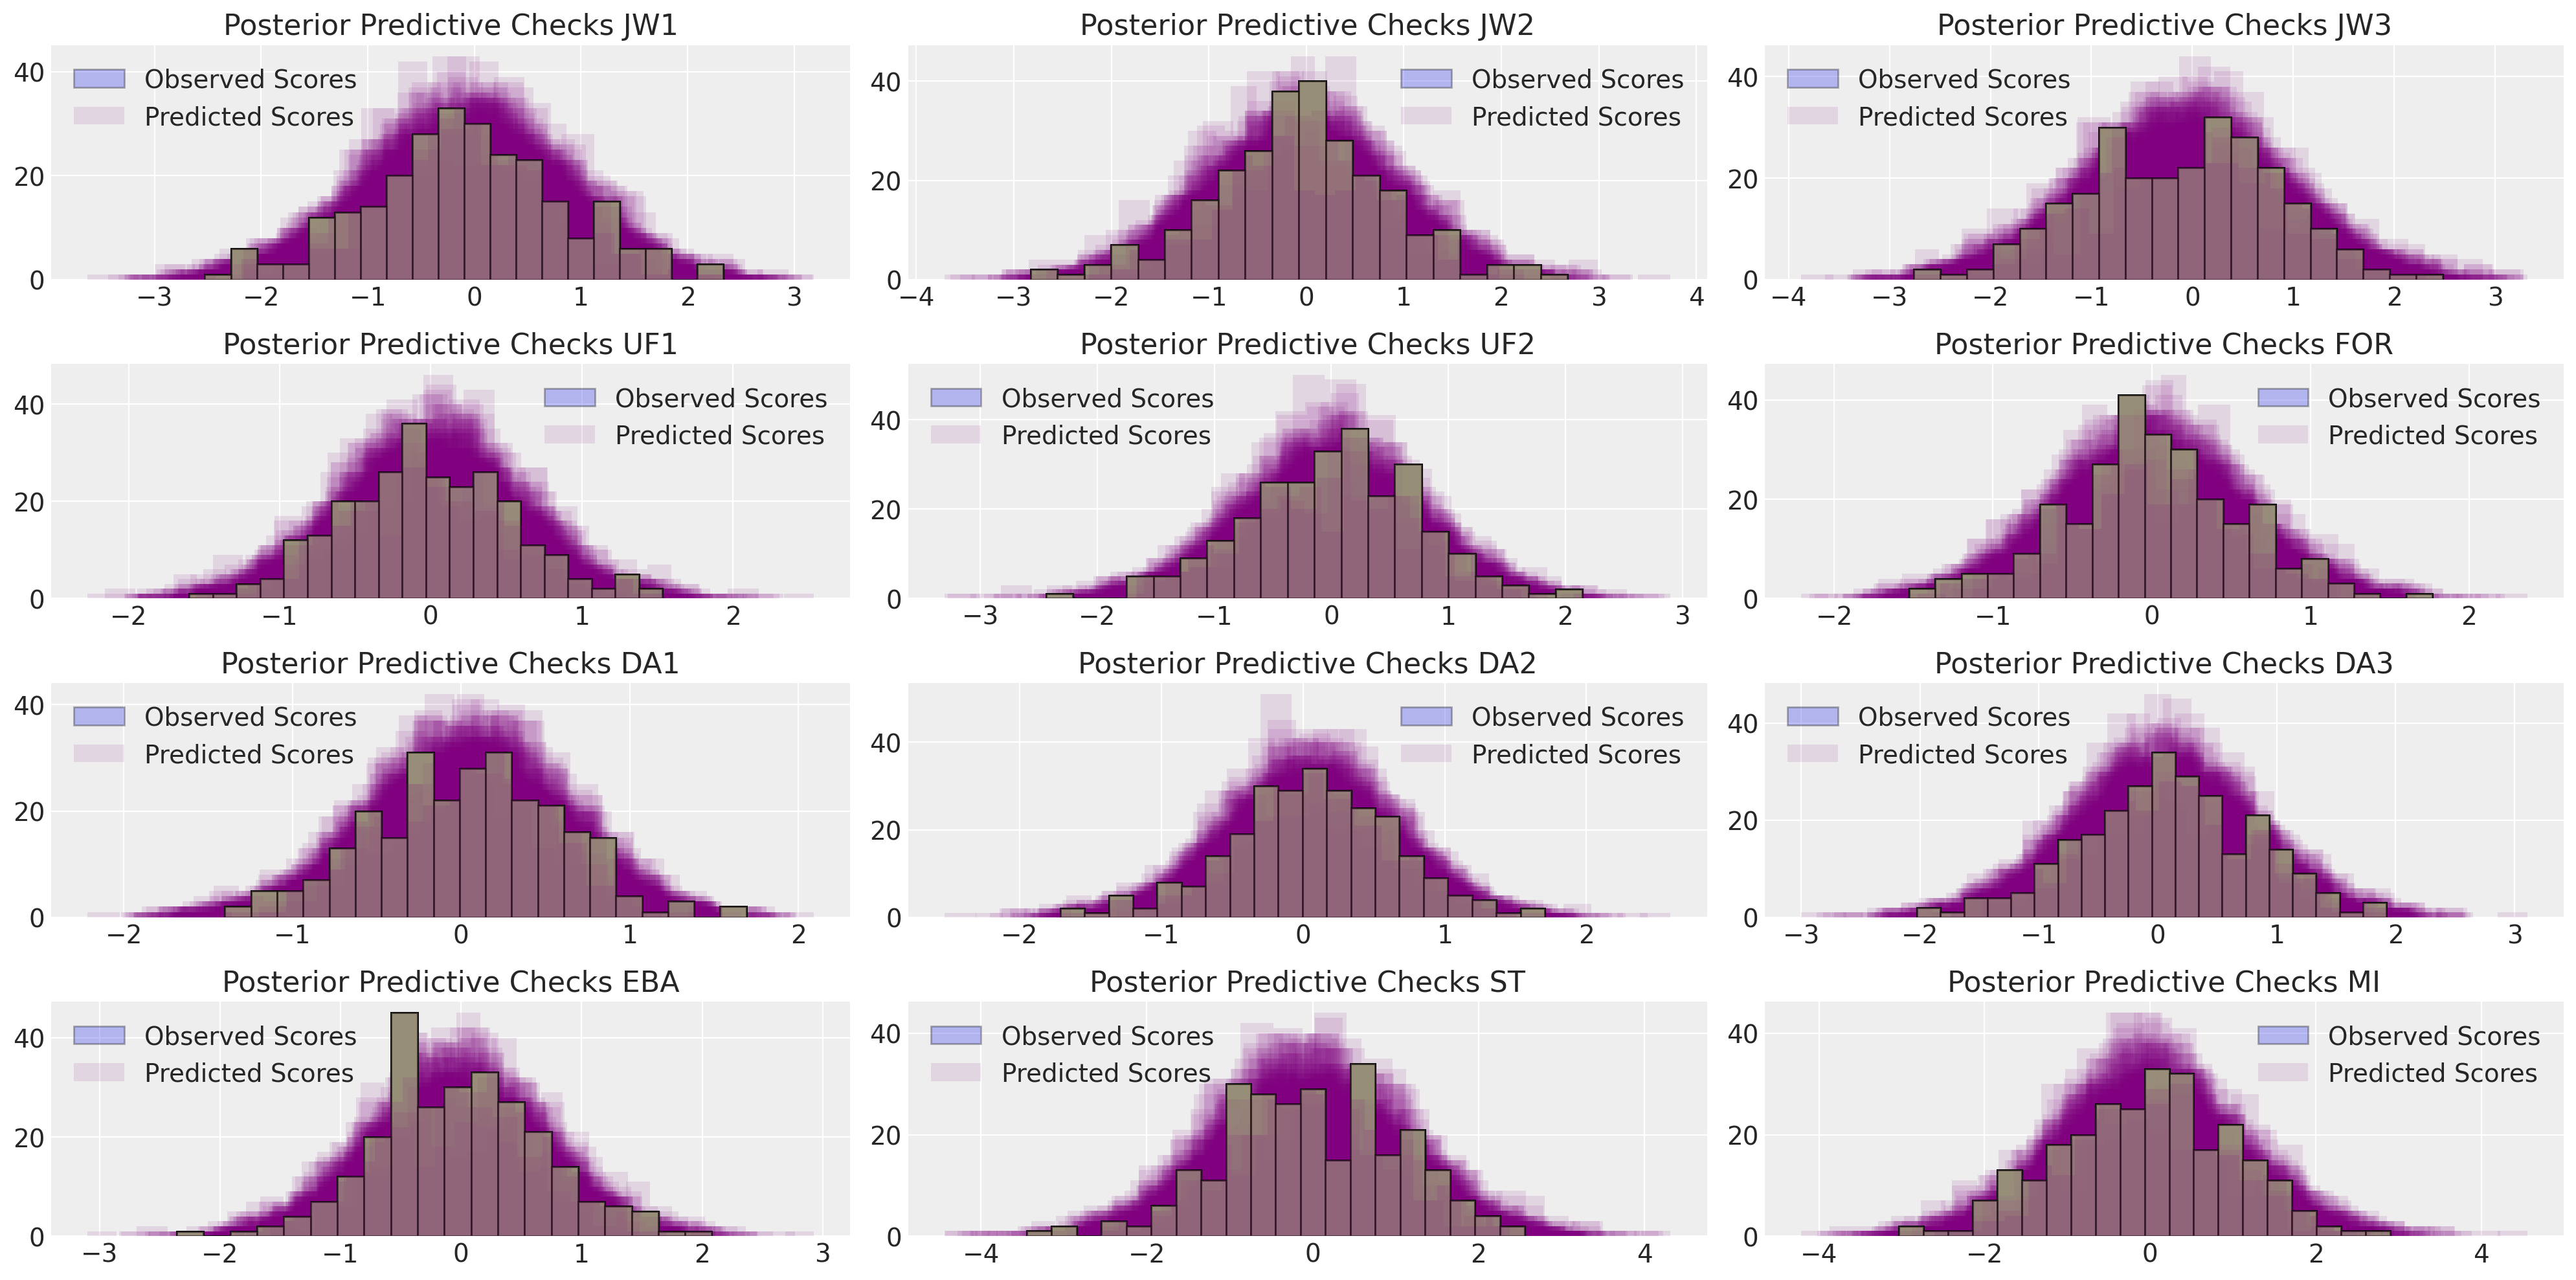

In [105]:
make_ppc(idata_cfa_model_v0, sample_df, dims=(4, 3));

## CFA v1

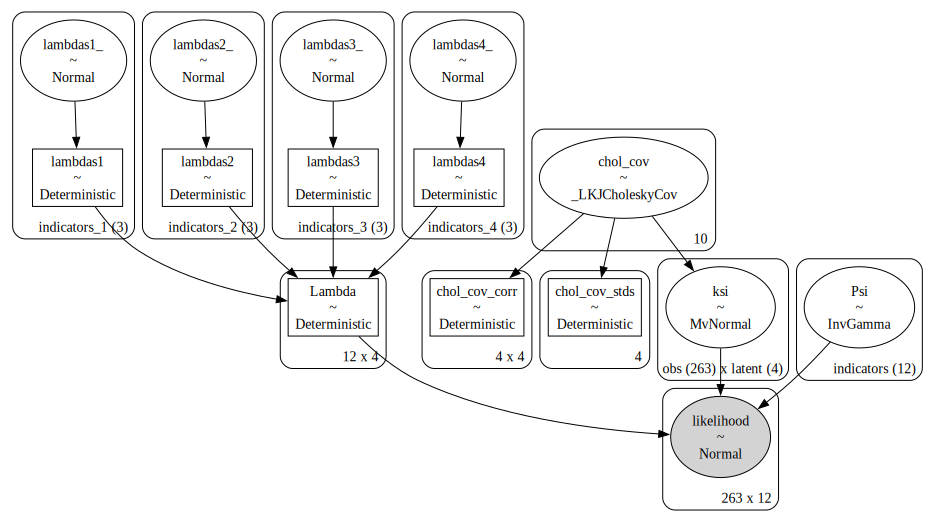

In [ ]:

with pm.Model(coords=coords) as cfa_model_v1:
    
    # --- Factor loadings ---
    lambdas_1 = make_lambda('indicators_1', 'lambdas1', priors=[1, .5])
    lambdas_2 = make_lambda('indicators_2', 'lambdas2', priors=[1, .5])
    lambdas_3 = make_lambda('indicators_3', 'lambdas3', priors=[1, .5])
    lambdas_4 = make_lambda('indicators_4', 'lambdas4', priors=[1, .5])

    Lambda = pt.zeros((12, 4))
    Lambda = pt.set_subtensor(Lambda[0:3, 0], lambdas_1)
    Lambda = pt.set_subtensor(Lambda[3:6, 1], lambdas_2)
    Lambda = pt.set_subtensor(Lambda[6:9, 2], lambdas_3)
    Lambda = pt.set_subtensor(Lambda[9:12, 3], lambdas_4)
    Lambda = pm.Deterministic('Lambda', Lambda)

    sd_dist = pm.Exponential.dist(1.0, shape=4)
    chol, _, _ = pm.LKJCholeskyCov("chol_cov", n=4, eta=2, sd_dist=sd_dist, compute_corr=True)
    eta = pm.MvNormal("eta", 0, chol=chol, dims=("obs", "latent"))

    # Construct Pseudo Observation matrix based on Factor Loadings
    mu = pt.dot(eta, Lambda.T)  # (n_obs, n_indicators)

    ## Error Terms
    Psi = pm.InverseGamma("Psi", 5, 10, dims="indicators")
    _ = pm.Normal('likelihood', mu=mu, sigma=Psi, observed=observed_data)

pm.model_to_graphviz(cfa_model_v1)

In [107]:
idata_cfa_model_v1 = sample_model(cfa_model_v1, sampler_kwargs=sampler_kwargs)

Sampling: [Psi, chol_cov, ksi, lambdas1_, lambdas2_, lambdas3_, lambdas4_, likelihood]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambdas1_, lambdas2_, lambdas3_, lambdas4_, chol_cov, ksi, Psi]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

In [108]:
loo_1 = az.loo(idata_cfa_model_v0, pointwise=True)
loo_2 = az.loo(idata_cfa_model_v1, pointwise=True)

# compare the two models
az.compare({"cfa_model_v1": idata_cfa_model_v1, "cfa_model_v0": idata_cfa_model_v0}, ic="loo")

rank     elpd_loo       p_loo  elpd_diff   weight         se  \
cfa_model_v0     0 -2870.849636  662.531561   0.000000  0.53128  40.865816   
cfa_model_v1     1 -2870.975730  661.681227   0.126094  0.46872  40.793275   

                   dse  warning scale  
cfa_model_v0  0.000000     True   log  
cfa_model_v1  2.027367     True   log

## SEM V0

In [109]:

with pm.Model(coords=coords) as sem_model_v0:
    
    # --- Factor loadings ---
    lambdas_1 = make_lambda('indicators_1', 'lambdas1', priors=[1, .5])
    lambdas_2 = make_lambda('indicators_2', 'lambdas2', priors=[1, .5])
    lambdas_3 = make_lambda('indicators_3', 'lambdas3', priors=[1, .5])
    lambdas_4 = make_lambda('indicators_4', 'lambdas4', priors=[1, .5])

    Lambda = pt.zeros((12, 4))
    Lambda = pt.set_subtensor(Lambda[0:3, 0], lambdas_1)
    Lambda = pt.set_subtensor(Lambda[3:6, 1], lambdas_2)
    Lambda = pt.set_subtensor(Lambda[6:9, 2], lambdas_3)
    Lambda = pt.set_subtensor(Lambda[9:12, 3], lambdas_4)
    Lambda = pm.Deterministic('Lambda', Lambda)

    # --- Latent variables (η) ---
    sd_dist = pm.Exponential.dist(1.0, shape=4)
    chol, _, _ = pm.LKJCholeskyCov("chol_cov", n=4, eta=2, sd_dist=sd_dist, compute_corr=True)
    eta = pm.MvNormal("eta", 0, chol=chol, dims=("obs", "latent"))

    # --- Structural relations (Bη) ---
    B = make_B()
    eta_hat = pm.Deterministic('eta_hat', pm.math.dot(eta, B))

    # --- Linear predictor: Λη + Bη ---
    m1 = eta[obs_idx, 0] * lambdas_1[0] + eta_hat[obs_idx, 0]
    m2 = eta[obs_idx, 0] * lambdas_1[1] + eta_hat[obs_idx, 0]
    m3 = eta[obs_idx, 0] * lambdas_1[2] + eta_hat[obs_idx, 0]
    m4 = eta[obs_idx, 1] * lambdas_2[0] + eta_hat[obs_idx, 1]
    m5 = eta[obs_idx, 1] * lambdas_2[1] + eta_hat[obs_idx, 1]
    m6 = eta[obs_idx, 1] * lambdas_2[2] + eta_hat[obs_idx, 1]
    m7 = eta[obs_idx, 2] * lambdas_3[0] + eta_hat[obs_idx, 2]
    m8 = eta[obs_idx, 2] * lambdas_3[1] + eta_hat[obs_idx, 2]
    m9 = eta[obs_idx, 2] * lambdas_3[2] + eta_hat[obs_idx, 2]
    m10 = eta[obs_idx, 3] * lambdas_4[0] + eta_hat[obs_idx, 3]
    m11 = eta[obs_idx, 3] * lambdas_4[1] + eta_hat[obs_idx, 3]
    m12 = eta[obs_idx, 3] * lambdas_4[2] + eta_hat[obs_idx, 3]

    mu = pm.Deterministic("mu", pm.math.stack([m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, m12]).T)

    ## Error Terms
    Psi = pm.InverseGamma("Psi", 5, 10, dims="indicators")
    _ = pm.Normal('likelihood', mu=mu, sigma=Psi, observed=observed_data)

In [110]:
idata_sem_model_v0 = sample_model(sem_model_v0, sampler_kwargs)

Sampling: [Psi, chol_cov, eta, lambdas1_, lambdas2_, lambdas3_, lambdas4_, likelihood, mu_betas]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambdas1_, lambdas2_, lambdas3_, lambdas4_, chol_cov, eta, mu_betas, Psi]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

## SEM V1 

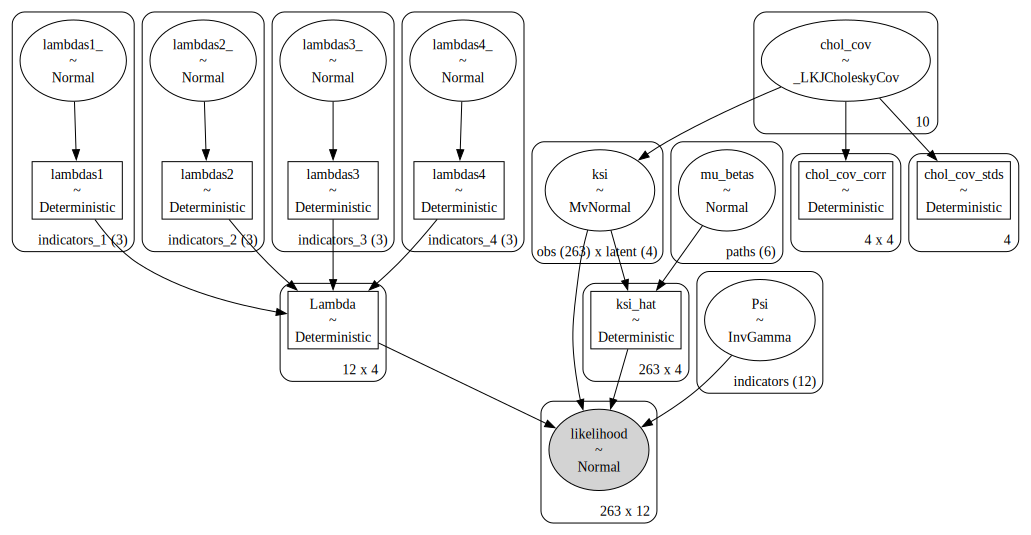

In [ ]:
with pm.Model(coords=coords) as sem_model_v1:
    
    # --- Factor loadings ---
    lambdas_1 = make_lambda('indicators_1', 'lambdas1', priors=[1, .5])
    lambdas_2 = make_lambda('indicators_2', 'lambdas2', priors=[1, .5])
    lambdas_3 = make_lambda('indicators_3', 'lambdas3', priors=[1, .5])
    lambdas_4 = make_lambda('indicators_4', 'lambdas4', priors=[1, .5])

    Lambda = pt.zeros((12, 4))
    Lambda = pt.set_subtensor(Lambda[0:3, 0], lambdas_1)
    Lambda = pt.set_subtensor(Lambda[3:6, 1], lambdas_2)
    Lambda = pt.set_subtensor(Lambda[6:9, 2], lambdas_3)
    Lambda = pt.set_subtensor(Lambda[9:12, 3], lambdas_4)
    Lambda = pm.Deterministic('Lambda', Lambda)

    sd_dist = pm.Exponential.dist(1.0, shape=4)
    chol, _, _ = pm.LKJCholeskyCov("chol_cov", n=4, eta=2, sd_dist=sd_dist, compute_corr=True)
    eta = pm.MvNormal("eta", 0, chol=chol, dims=("obs", "latent"))

    B = make_B()
    eta_hat = pm.Deterministic('eta_hat', pm.math.dot(eta, B))

    # Construct Pseudo Observation matrix based on Factor Loadings
    mu = pt.dot(eta + eta_hat, Lambda.T)  # (n_obs, n_indicators)

    ## Error Terms
    Psi = pm.InverseGamma("Psi", 5, 10, dims="indicators")
    _ = pm.Normal('likelihood', mu=mu, sigma=Psi, observed=observed_data)

pm.model_to_graphviz(sem_model_v1)

In [112]:
idata_sem_model_v1 = sample_model(sem_model_v1, sampler_kwargs)

Sampling: [Psi, chol_cov, ksi, lambdas1_, lambdas2_, lambdas3_, lambdas4_, likelihood, mu_betas]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambdas1_, lambdas2_, lambdas3_, lambdas4_, chol_cov, ksi, mu_betas, Psi]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

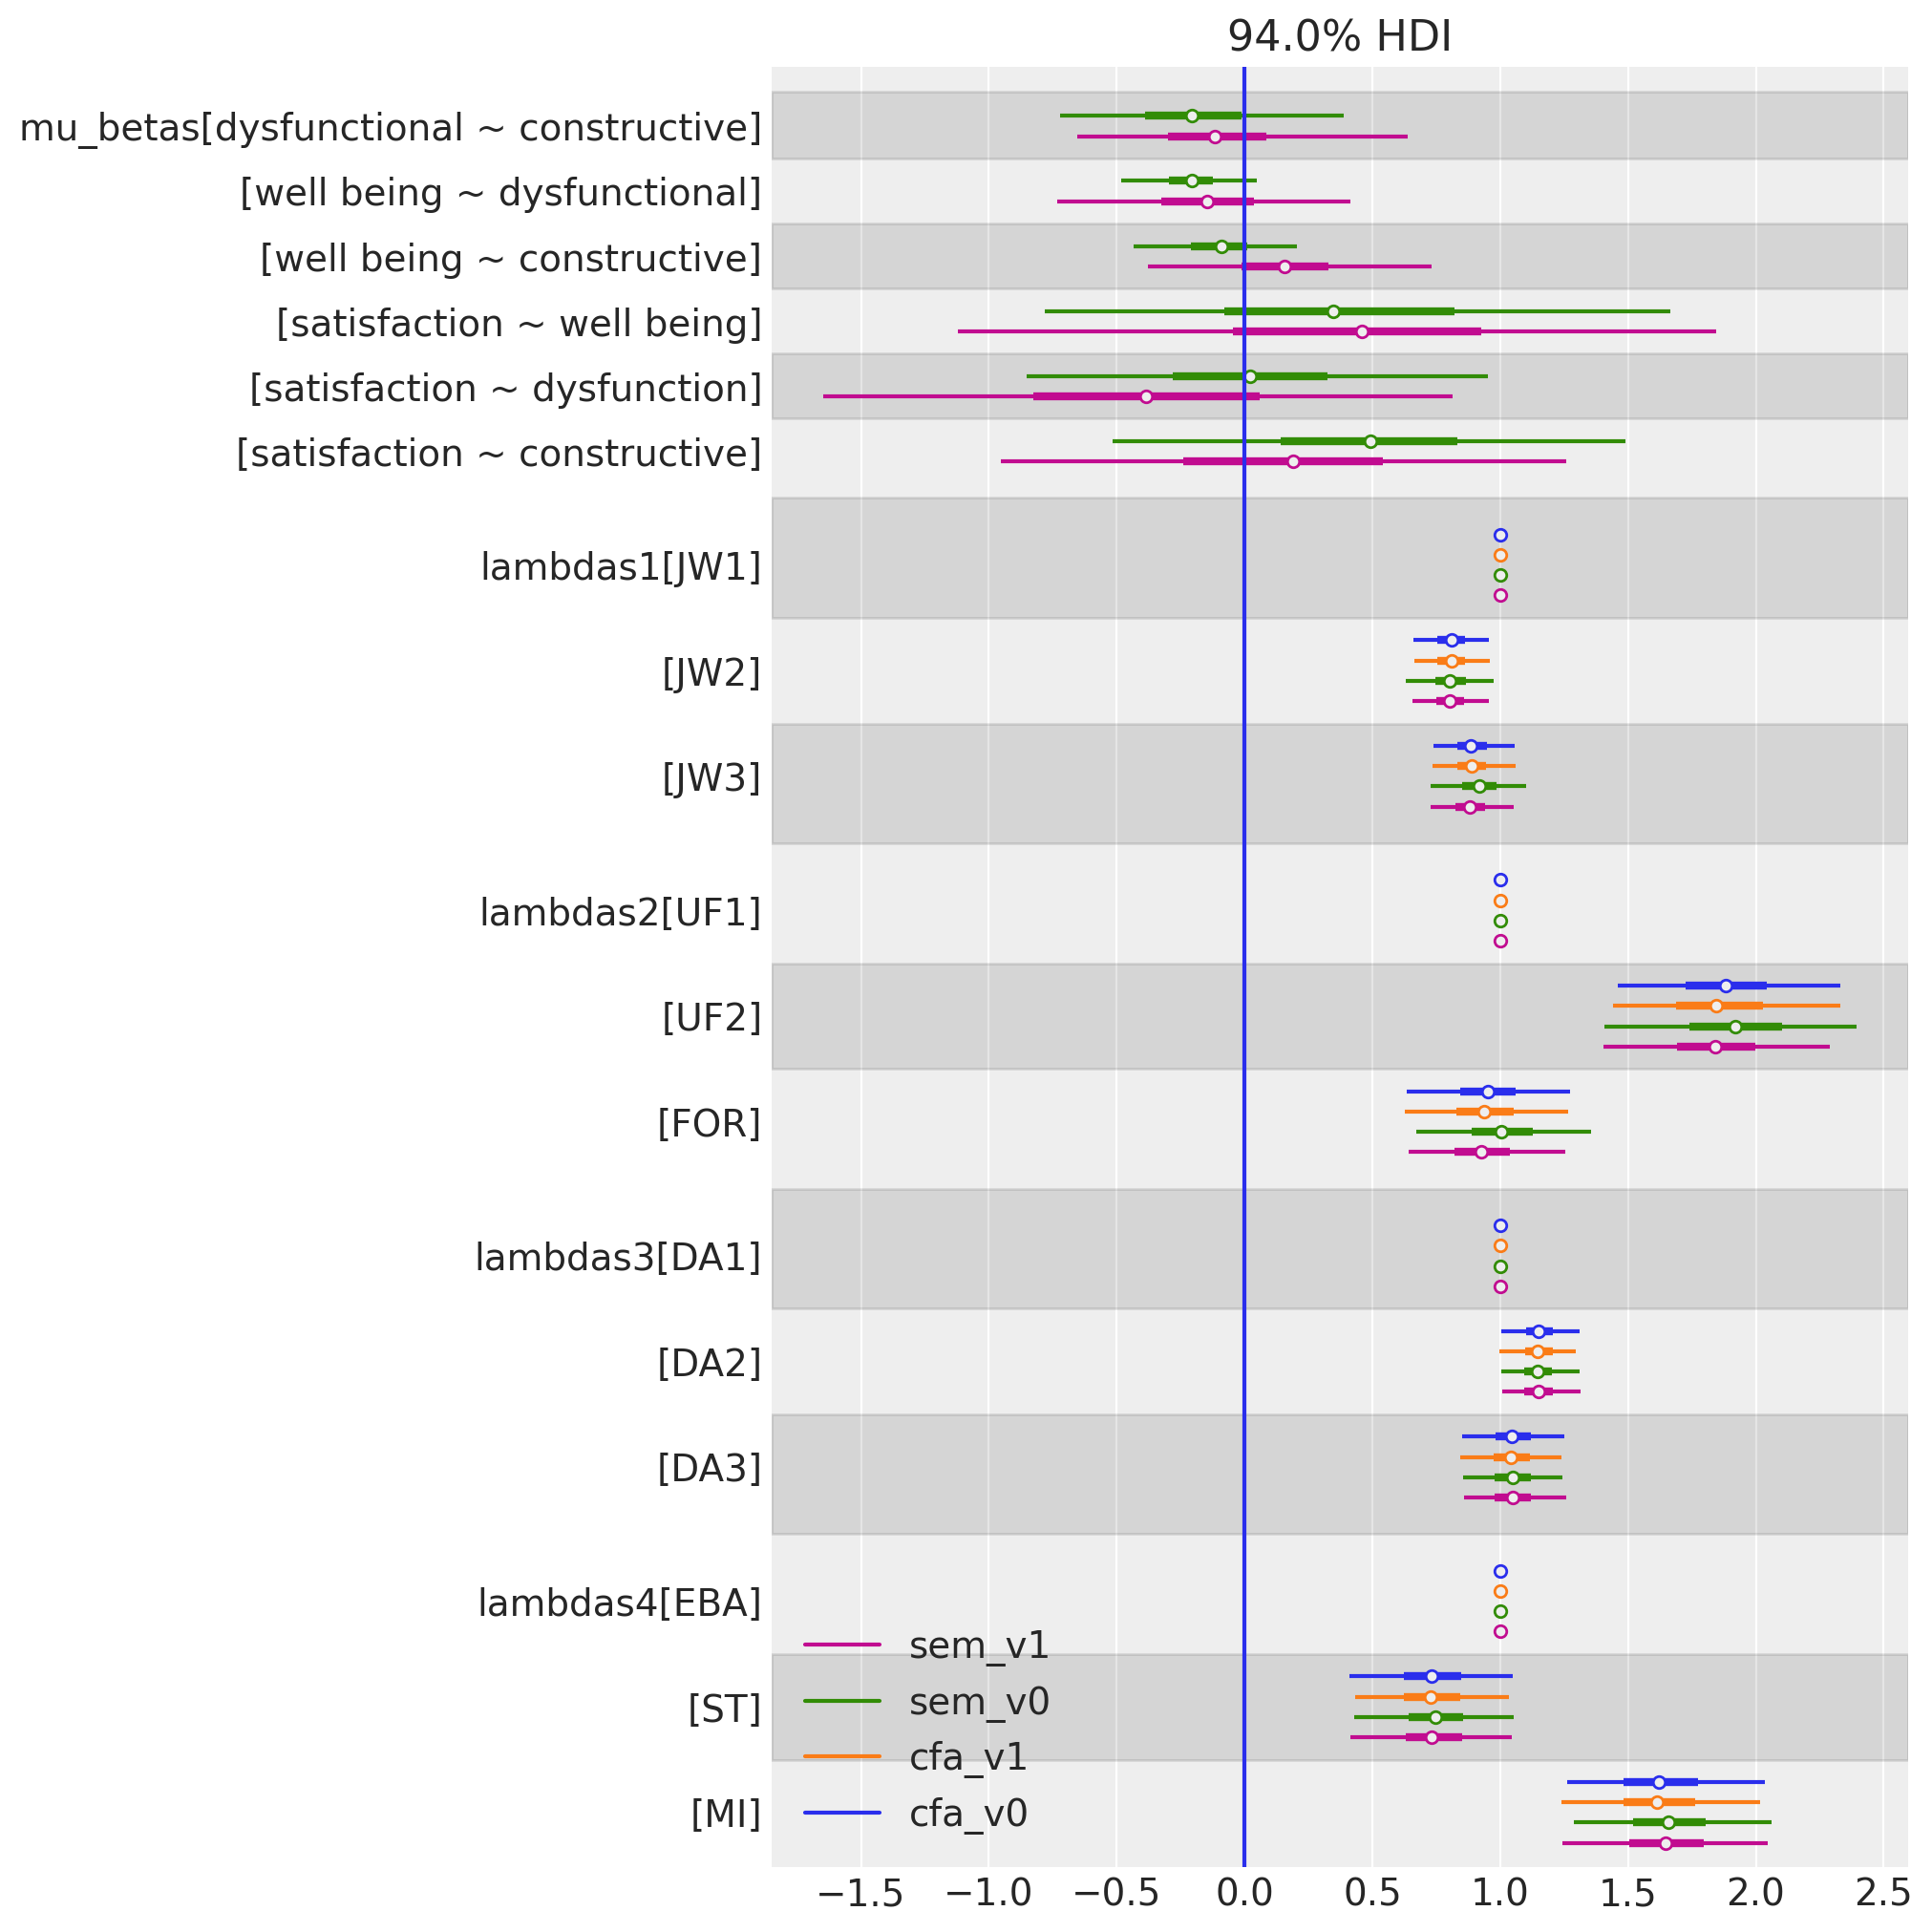

In [113]:
axs = az.plot_forest([idata_cfa_model_v0, idata_cfa_model_v1, idata_sem_model_v0,
                idata_sem_model_v1], var_names=['mu_betas', 'lambdas1', 'lambdas2', 'lambdas3', 'lambdas4'], 
                model_names=['cfa_v0', 'cfa_v1', 'sem_v0', 'sem_v1'], combined=True, figsize=(10, 10))
axs[0].axvline(0)

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

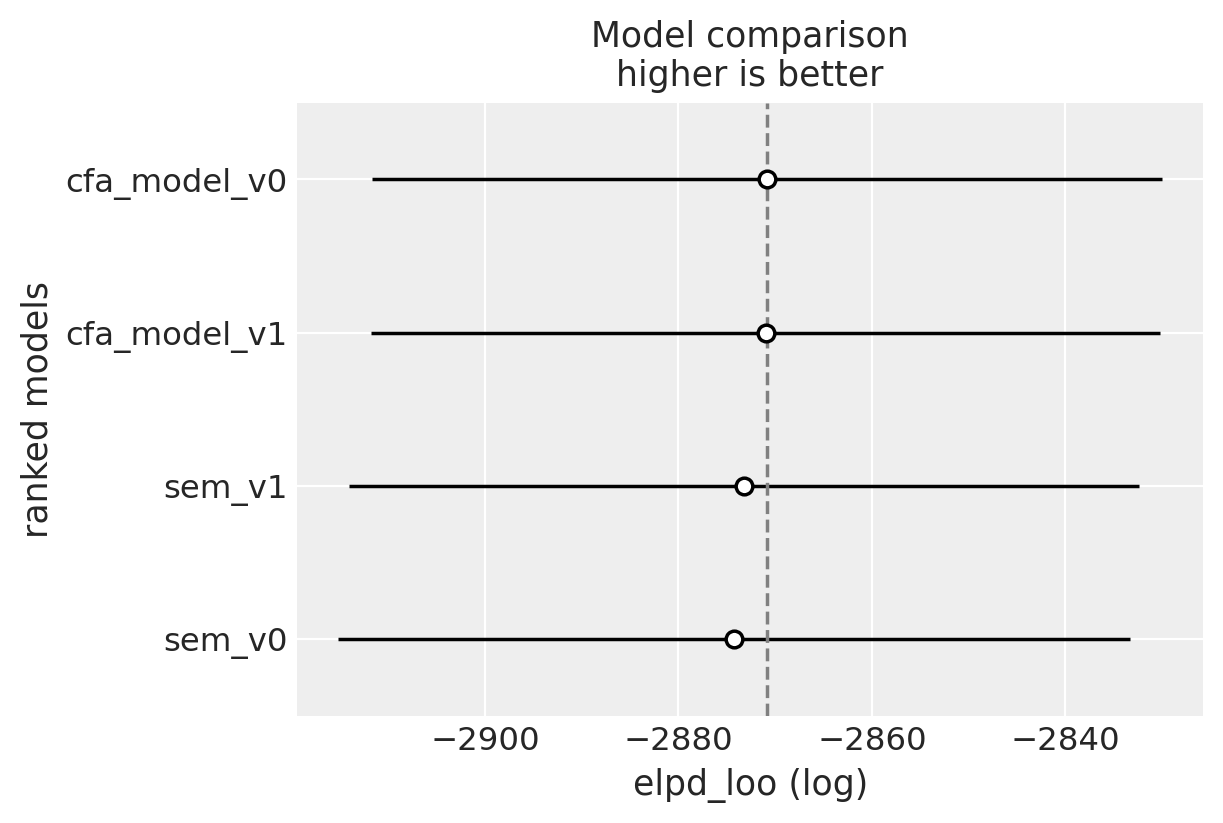

In [114]:
# compare the two models
compare_df = az.compare({"cfa_model_v1": idata_cfa_model_v1, "cfa_model_v0": idata_cfa_model_v0, 
            'sem_v0': idata_sem_model_v0, 'sem_v1': idata_sem_model_v1}, ic="loo")

az.plot_compare(compare_df)

## SEM with Covariance Structures


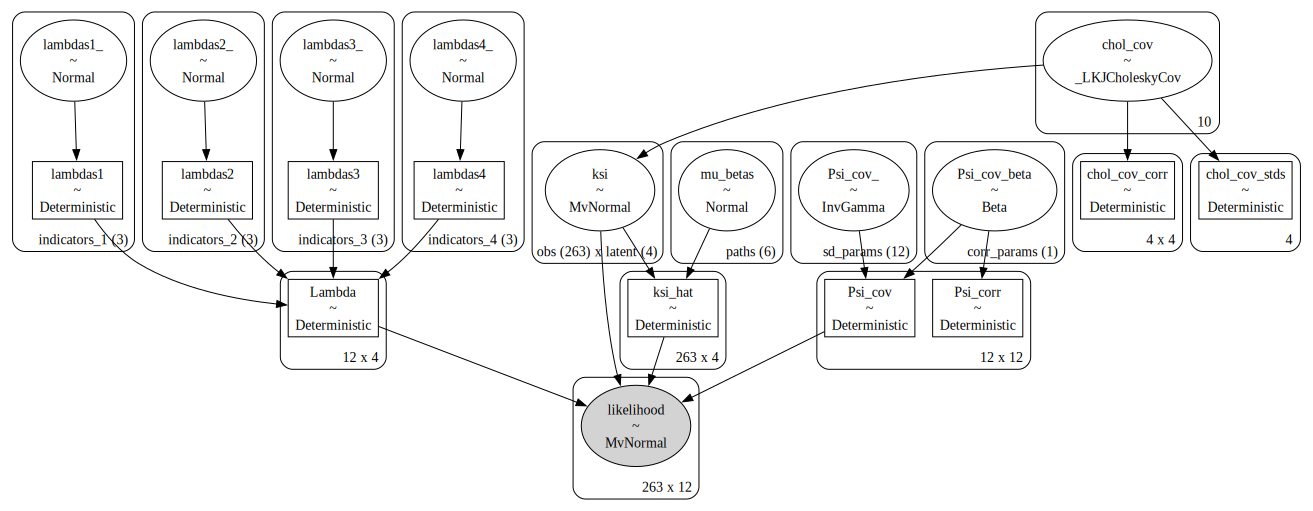

In [ ]:
with pm.Model(coords=coords) as sem_model_v2:
    
    # --- Factor loadings ---
    lambdas_1 = make_lambda('indicators_1', 'lambdas1', priors=[1, .5])
    lambdas_2 = make_lambda('indicators_2', 'lambdas2', priors=[1, .5])
    lambdas_3 = make_lambda('indicators_3', 'lambdas3', priors=[1, .5])
    lambdas_4 = make_lambda('indicators_4', 'lambdas4', priors=[1, .5])

    Lambda = pt.zeros((12, 4))
    Lambda = pt.set_subtensor(Lambda[0:3, 0], lambdas_1)
    Lambda = pt.set_subtensor(Lambda[3:6, 1], lambdas_2)
    Lambda = pt.set_subtensor(Lambda[6:9, 2], lambdas_3)
    Lambda = pt.set_subtensor(Lambda[9:12, 3], lambdas_4)
    Lambda = pm.Deterministic('Lambda', Lambda)

    sd_dist = pm.Exponential.dist(1.0, shape=4)
    chol, _, _ = pm.LKJCholeskyCov("chol_cov", n=4, eta=2, sd_dist=sd_dist, compute_corr=True)
    eta = pm.MvNormal("eta", 0, chol=chol, dims=("obs", "latent"))

    B = make_B()
    eta_hat = pm.Deterministic('eta_hat', pm.math.dot(eta, B))

    # Construct Pseudo Observation matrix based on Factor Loadings
    mu = pt.dot(eta + eta_hat, Lambda.T)  # (n_obs, n_indicators)

    ## Error Terms
    Psi = make_Psi('indicators')
    _ = pm.MvNormal('likelihood', mu=mu, cov=Psi, observed=observed_data)

pm.model_to_graphviz(sem_model_v2)

In [116]:
idata_sem_model_v2 = sample_model(sem_model_v2, sampler_kwargs)

Sampling: [Psi_cov_, Psi_cov_beta, chol_cov, ksi, lambdas1_, lambdas2_, lambdas3_, lambdas4_, likelihood, mu_betas]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambdas1_, lambdas2_, lambdas3_, lambdas4_, chol_cov, ksi, mu_betas, Psi_cov_, Psi_cov_beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 90 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

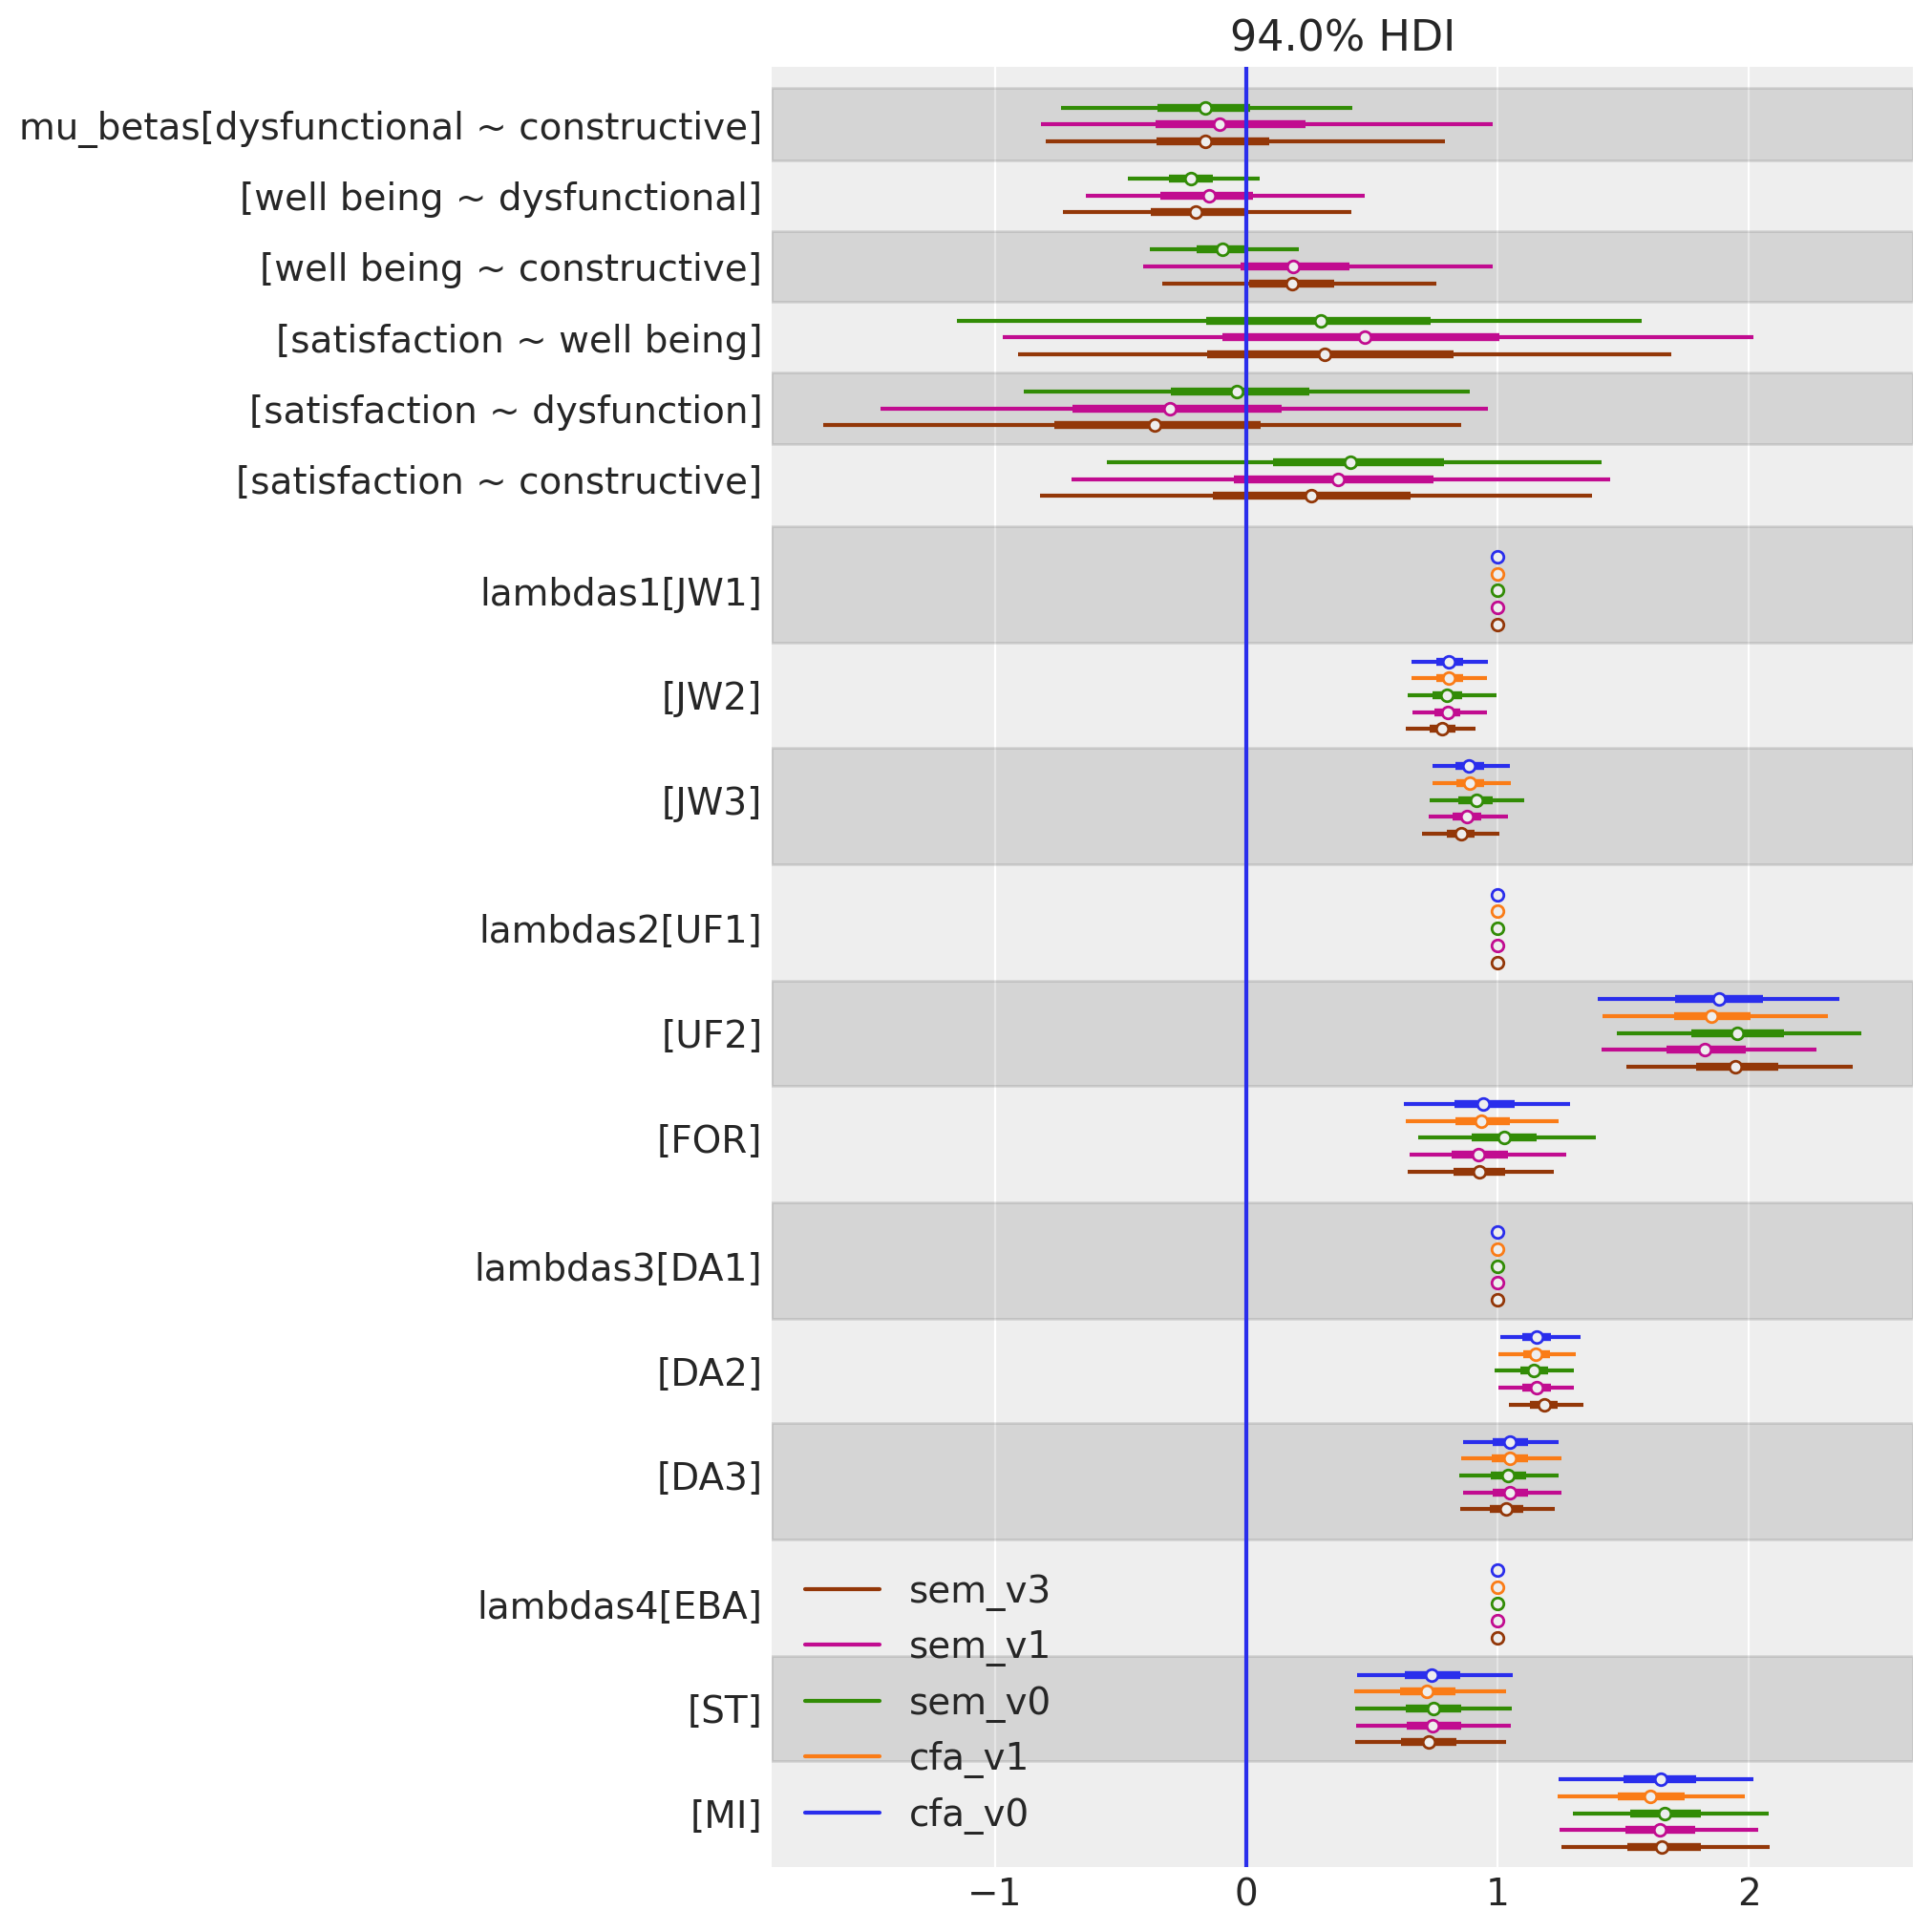

In [ ]:
axs = az.plot_forest([idata_cfa_model_v0, idata_cfa_model_v1, idata_sem_model_v0,
                idata_sem_model_v1, idata_sem_model_v2], var_names=['mu_betas', 'lambdas1', 'lambdas2', 'lambdas3', 'lambdas4'], 
                model_names=['cfa_v0', 'cfa_v1', 'sem_v0', 'sem_v1', 'sem_v2'], combined=True, figsize=(10, 10))
axs[0].axvline(0)

## SEM v3

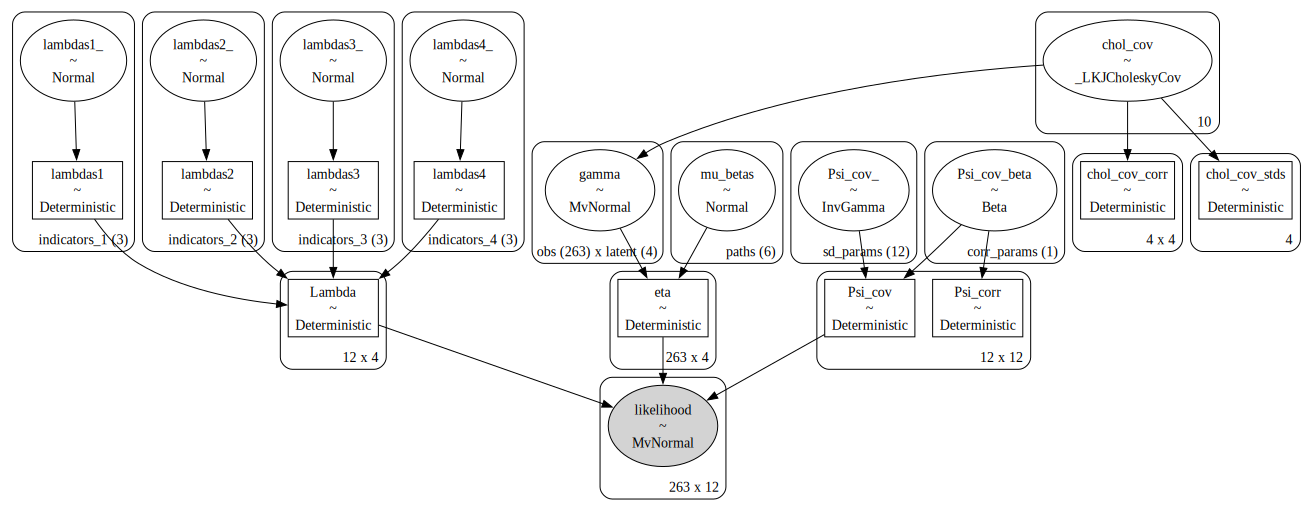

In [117]:
with pm.Model(coords=coords) as sem_model_v3:
    
    # --- Factor loadings ---
    lambdas_1 = make_lambda('indicators_1', 'lambdas1', priors=[1, .5])
    lambdas_2 = make_lambda('indicators_2', 'lambdas2', priors=[1, .5])
    lambdas_3 = make_lambda('indicators_3', 'lambdas3', priors=[1, .5])
    lambdas_4 = make_lambda('indicators_4', 'lambdas4', priors=[1, .5])

    Lambda = pt.zeros((12, 4))
    Lambda = pt.set_subtensor(Lambda[0:3, 0], lambdas_1)
    Lambda = pt.set_subtensor(Lambda[3:6, 1], lambdas_2)
    Lambda = pt.set_subtensor(Lambda[6:9, 2], lambdas_3)
    Lambda = pt.set_subtensor(Lambda[9:12, 3], lambdas_4)
    Lambda = pm.Deterministic('Lambda', Lambda)

    latent_dim = len(coords['latent'])

    sd_dist = pm.Exponential.dist(1.0, shape=latent_dim)
    chol, _, _ = pm.LKJCholeskyCov("chol_cov", n=latent_dim, eta=2, sd_dist=sd_dist, compute_corr=True)
    gamma = pm.MvNormal("gamma", 0, chol=chol, dims=("obs", "latent"))

    B = make_B()
    I = pt.eye(latent_dim)
    eta = pm.Deterministic("eta", pt.slinalg.solve(I - B + 1e-8 * I, gamma.T).T)  

    mu = pt.dot(eta, Lambda.T)

    ## Error Terms
    Psi = make_Psi('indicators')
    _ = pm.MvNormal('likelihood', mu=mu, cov=Psi, observed=observed_data)

pm.model_to_graphviz(sem_model_v3)

In [118]:
idata_sem_model_v3 = sample_model(sem_model_v3, sampler_kwargs)

Sampling: [Psi_cov_, Psi_cov_beta, chol_cov, gamma, lambdas1_, lambdas2_, lambdas3_, lambdas4_, likelihood, mu_betas]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambdas1_, lambdas2_, lambdas3_, lambdas4_, chol_cov, gamma, mu_betas, Psi_cov_, Psi_cov_beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 104 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

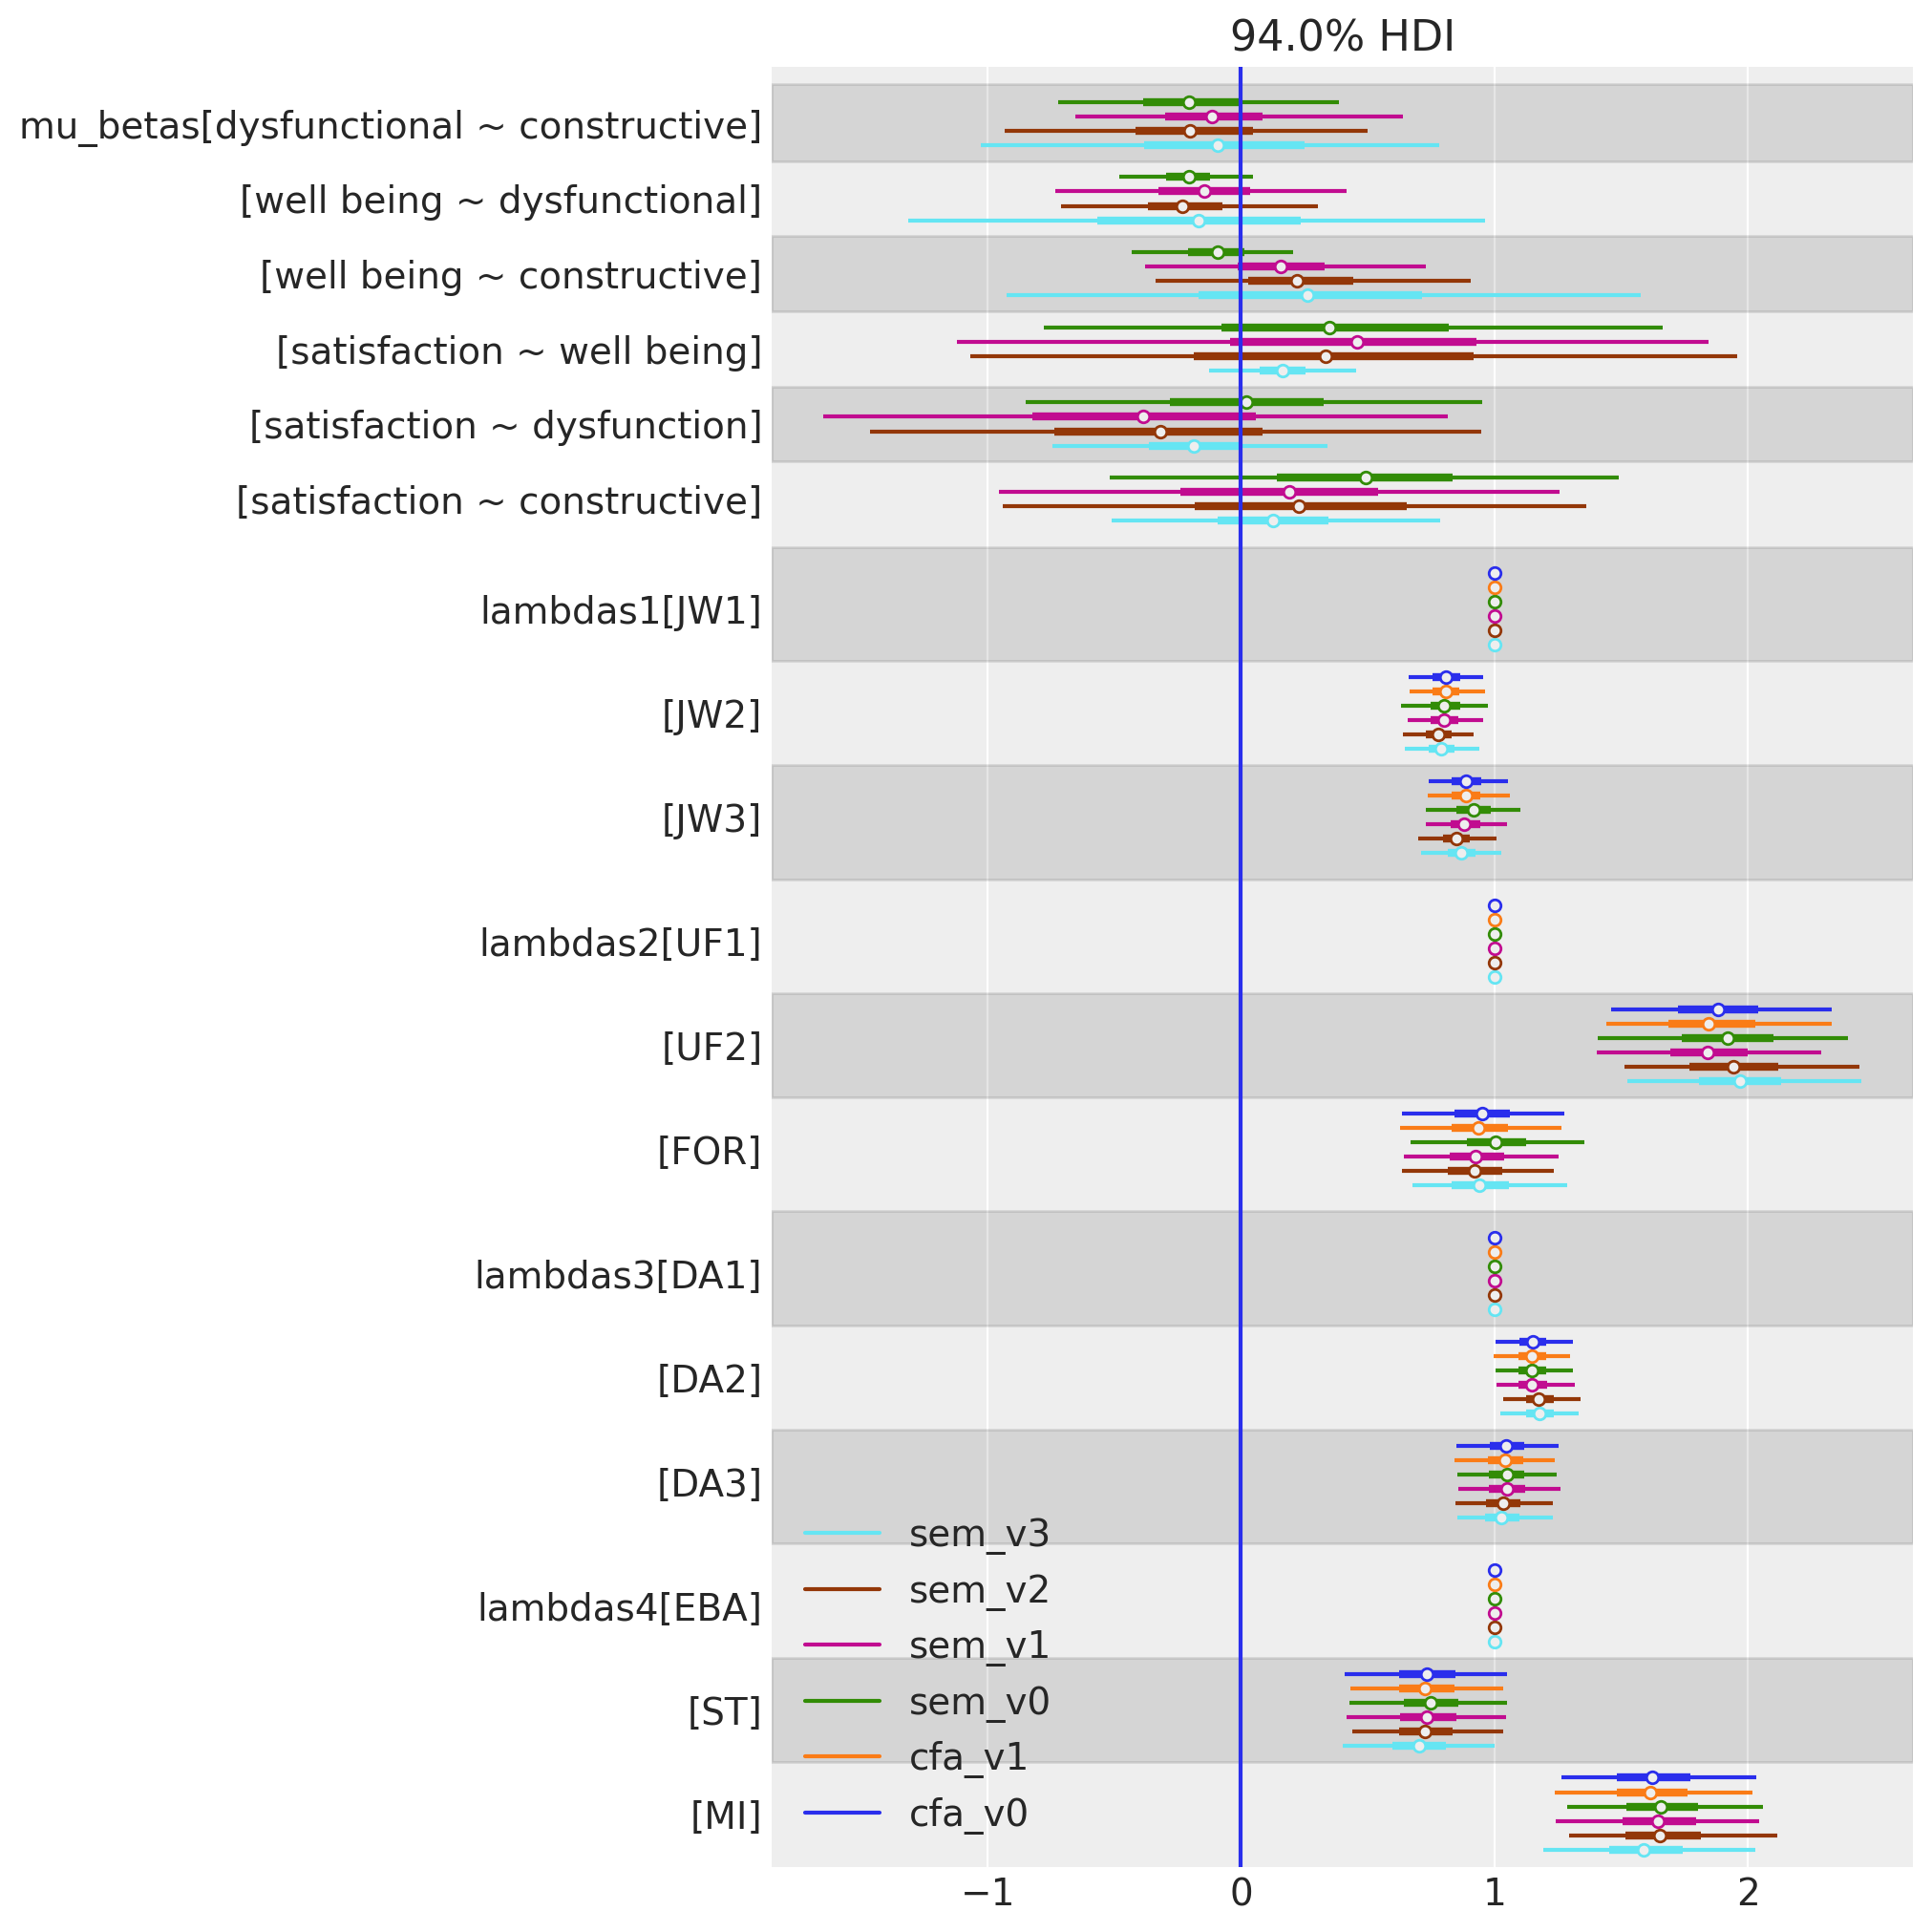

In [119]:
axs = az.plot_forest([idata_cfa_model_v0, idata_cfa_model_v1, idata_sem_model_v0,
                idata_sem_model_v1, idata_sem_model_v2, idata_sem_model_v3], var_names=['mu_betas', 'lambdas1', 'lambdas2', 'lambdas3', 'lambdas4'], 
                model_names=['cfa_v0', 'cfa_v1', 'sem_v0', 'sem_v1', 'sem_v2', 'sem_v3'], combined=True, figsize=(10, 10))
axs[0].axvline(0)

In [120]:
# compare the two models
compare_df = az.compare({
            'sem_v2': idata_sem_model_v2, 'sem_v3': idata_sem_model_v3}, ic="loo")
compare_df

rank     elpd_loo       p_loo  elpd_diff    weight         se  \
sem_v3     0 -2879.591016  671.151027   0.000000  0.625218  36.049651   
sem_v2     1 -2884.678000  680.954961   5.086984  0.374782  35.544989   

             dse  warning scale  
sem_v3  0.000000     True   log  
sem_v2  6.896597     True   log

## SEM V4

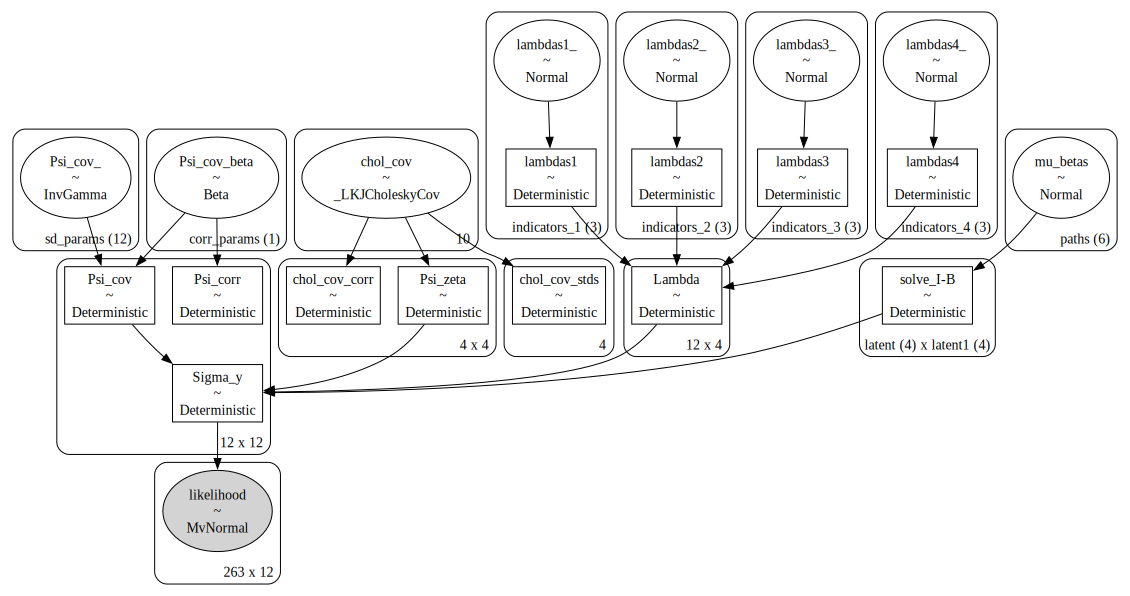

In [121]:
with pm.Model(coords=coords) as sem_model_v4:
    
    # --- Factor loadings ---
    lambdas_1 = make_lambda('indicators_1', 'lambdas1', priors=[1, .5])
    lambdas_2 = make_lambda('indicators_2', 'lambdas2', priors=[1, .5])
    lambdas_3 = make_lambda('indicators_3', 'lambdas3', priors=[1, .5])
    lambdas_4 = make_lambda('indicators_4', 'lambdas4', priors=[1, .5])

    Lambda = pt.zeros((12, 4))
    Lambda = pt.set_subtensor(Lambda[0:3, 0], lambdas_1)
    Lambda = pt.set_subtensor(Lambda[3:6, 1], lambdas_2)
    Lambda = pt.set_subtensor(Lambda[6:9, 2], lambdas_3)
    Lambda = pt.set_subtensor(Lambda[9:12, 3], lambdas_4)
    Lambda = pm.Deterministic('Lambda', Lambda)

    sd_dist = pm.Exponential.dist(1.0, shape=4)
    chol, _, _ = pm.LKJCholeskyCov("chol_cov", n=4, eta=2, sd_dist=sd_dist, compute_corr=True)

    Psi_zeta = pm.Deterministic("Psi_zeta", chol.dot(chol.T))
    Psi = make_Psi('indicators')

    B = make_B()
    latent_dim = len(coords['latent'])
    I = pt.eye(latent_dim)
    lhs = I - B + 1e-8 * pt.eye(latent_dim)  # (latent_dim, latent_dim)
    inv_lhs = pm.Deterministic('solve_I-B', pt.slinalg.solve(lhs, pt.eye(latent_dim)), dims=('latent', 'latent1'))

    Sigma_y = pm.Deterministic('Sigma_y', Lambda.dot(inv_lhs).dot(Psi_zeta).dot(inv_lhs.T).dot(Lambda.T) + Psi)
    _ = pm.MvNormal("likelihood", mu=0, cov=Sigma_y, observed=observed_data)

pm.model_to_graphviz(sem_model_v4)

In [122]:
idata_sem_model_v4 = sample_model(sem_model_v4, sampler_kwargs)

Sampling: [Psi_cov_, Psi_cov_beta, chol_cov, lambdas1_, lambdas2_, lambdas3_, lambdas4_, likelihood, mu_betas]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambdas1_, lambdas2_, lambdas3_, lambdas4_, chol_cov, Psi_cov_, Psi_cov_beta, mu_betas]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [likelihood]


Output()

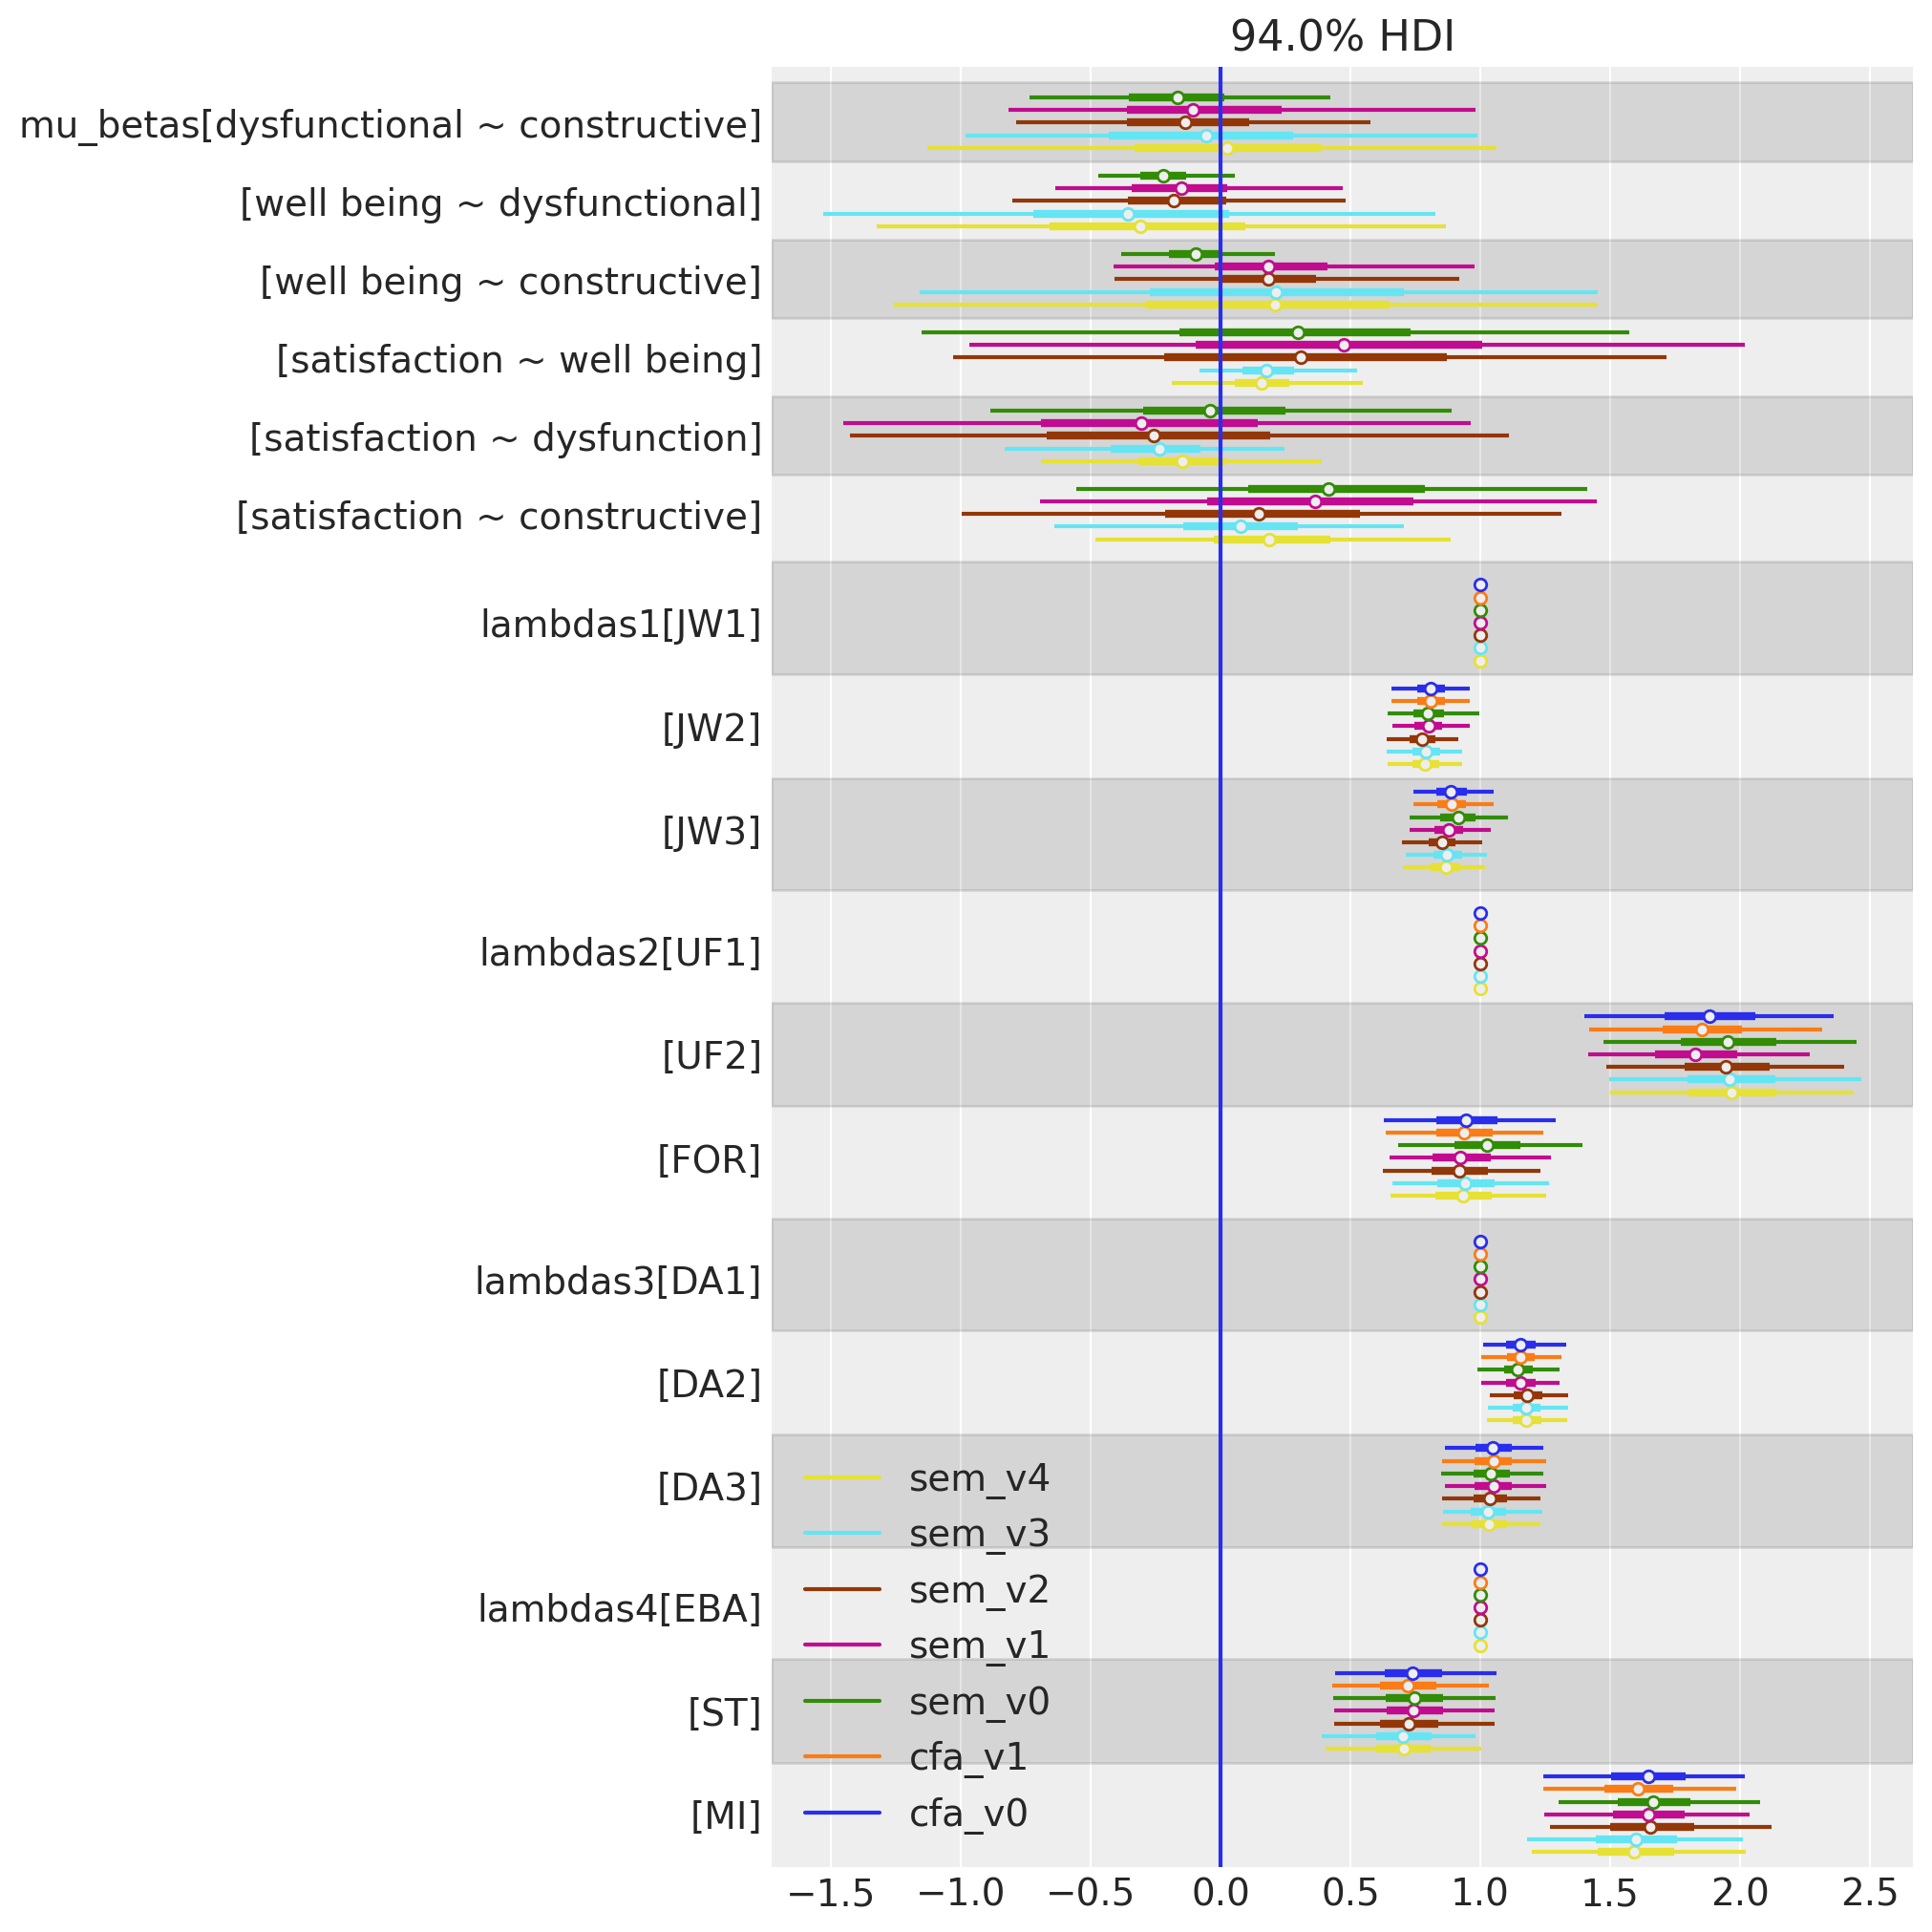

In [100]:
axs = az.plot_forest([idata_cfa_model_v0, idata_cfa_model_v1, idata_sem_model_v0,
                idata_sem_model_v1, idata_sem_model_v2, idata_sem_model_v3, idata_sem_model_v4], var_names=['mu_betas', 'lambdas1', 'lambdas2', 'lambdas3', 'lambdas4'], 
                model_names=['cfa_v0', 'cfa_v1', 'sem_v0', 'sem_v1', 'sem_v2', 'sem_v3', 'sem_v4'], combined=True, figsize=(10, 10))
axs[0].axvline(0)

## Mean Structure SEM

In [134]:
mean_shift_data = observed_data.copy()
mean_shift_data[:, [1, 5, 8]] = mean_shift_data[:, [1, 5, 8]] + 3
pd.DataFrame(mean_shift_data).mean()

0    -0.089077
1     2.929702
2    -0.130777
3    -0.017898
4     0.022297
5     2.993944
6     0.033940
7     0.051632
8     3.074532
9    -0.024823
10   -0.014593
11   -0.063020
dtype: float64

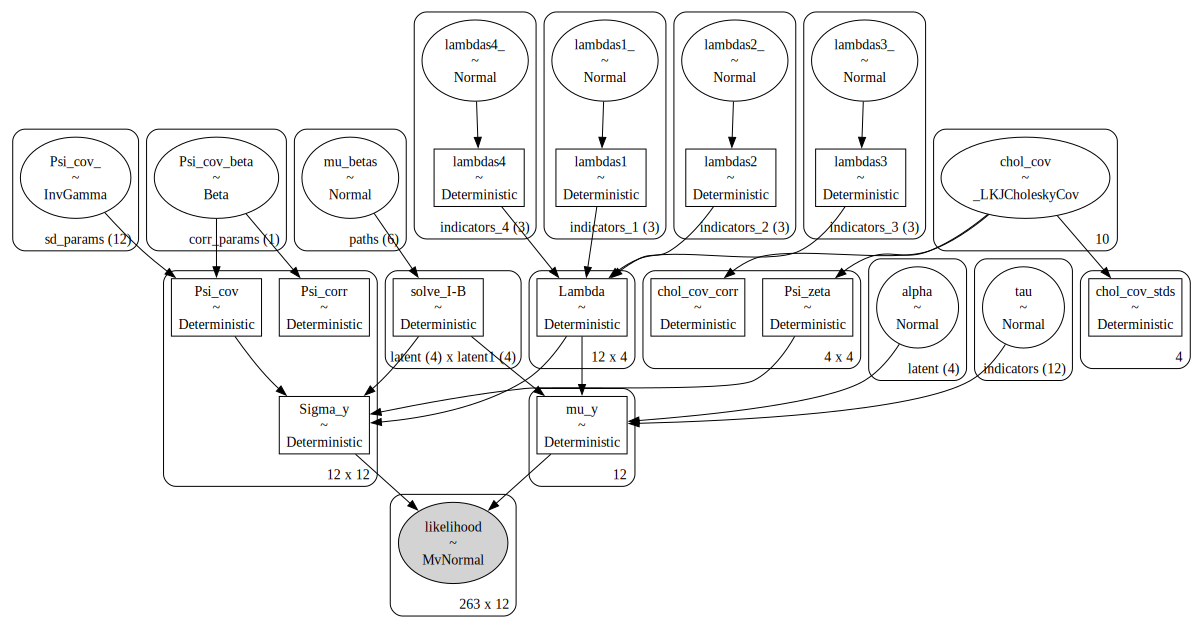

In [135]:
with pm.Model(coords=coords) as sem_model_mean_structure:
    
    # --- Factor loadings ---
    lambdas_1 = make_lambda('indicators_1', 'lambdas1', priors=[1, .5])
    lambdas_2 = make_lambda('indicators_2', 'lambdas2', priors=[1, .5])
    lambdas_3 = make_lambda('indicators_3', 'lambdas3', priors=[1, .5])
    lambdas_4 = make_lambda('indicators_4', 'lambdas4', priors=[1, .5])

    Lambda = pt.zeros((12, 4))
    Lambda = pt.set_subtensor(Lambda[0:3, 0], lambdas_1)
    Lambda = pt.set_subtensor(Lambda[3:6, 1], lambdas_2)
    Lambda = pt.set_subtensor(Lambda[6:9, 2], lambdas_3)
    Lambda = pt.set_subtensor(Lambda[9:12, 3], lambdas_4)
    Lambda = pm.Deterministic('Lambda', Lambda)

    sd_dist = pm.Exponential.dist(1.0, shape=4)
    chol, _, _ = pm.LKJCholeskyCov("chol_cov", n=4, eta=2, sd_dist=sd_dist, compute_corr=True)

    Psi_zeta = pm.Deterministic("Psi_zeta", chol.dot(chol.T))
    Psi = make_Psi('indicators')

    B = make_B()
    latent_dim = len(coords['latent'])
    I = pt.eye(latent_dim)
    lhs = I - B + 1e-8 * pt.eye(latent_dim)  # (latent_dim, latent_dim)
    inv_lhs = pm.Deterministic('solve_I-B', pt.slinalg.solve(lhs, pt.eye(latent_dim)), dims=('latent', 'latent1'))

    # Mean Structure
    tau = pm.Normal("tau", mu=0, sigma=0.5, dims="indicators")   # observed intercepts 
    alpha = pm.Normal("alpha", mu=0, sigma=0.5, dims="latent")       # latent means
    mu_y = pm.Deterministic("mu_y", tau + pt.dot(Lambda, pt.dot(inv_lhs, alpha)))

    Sigma_y = pm.Deterministic('Sigma_y', Lambda.dot(inv_lhs).dot(Psi_zeta).dot(inv_lhs.T).dot(Lambda.T) + Psi)
    _ = pm.MvNormal("likelihood", mu=mu_y, cov=Sigma_y, observed=mean_shift_data)

pm.model_to_graphviz(sem_model_mean_structure)


In [136]:
idata_sem_model_v5 = sample_model(sem_model_mean_structure, sampler_kwargs)

Sampling: [Psi_cov_, Psi_cov_beta, alpha, chol_cov, lambdas1_, lambdas2_, lambdas3_, lambdas4_, likelihood, mu_betas, tau]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambdas1_, lambdas2_, lambdas3_, lambdas4_, chol_cov, Psi_cov_, Psi_cov_beta, mu_betas, tau, alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 117 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [likelihood]


Output()

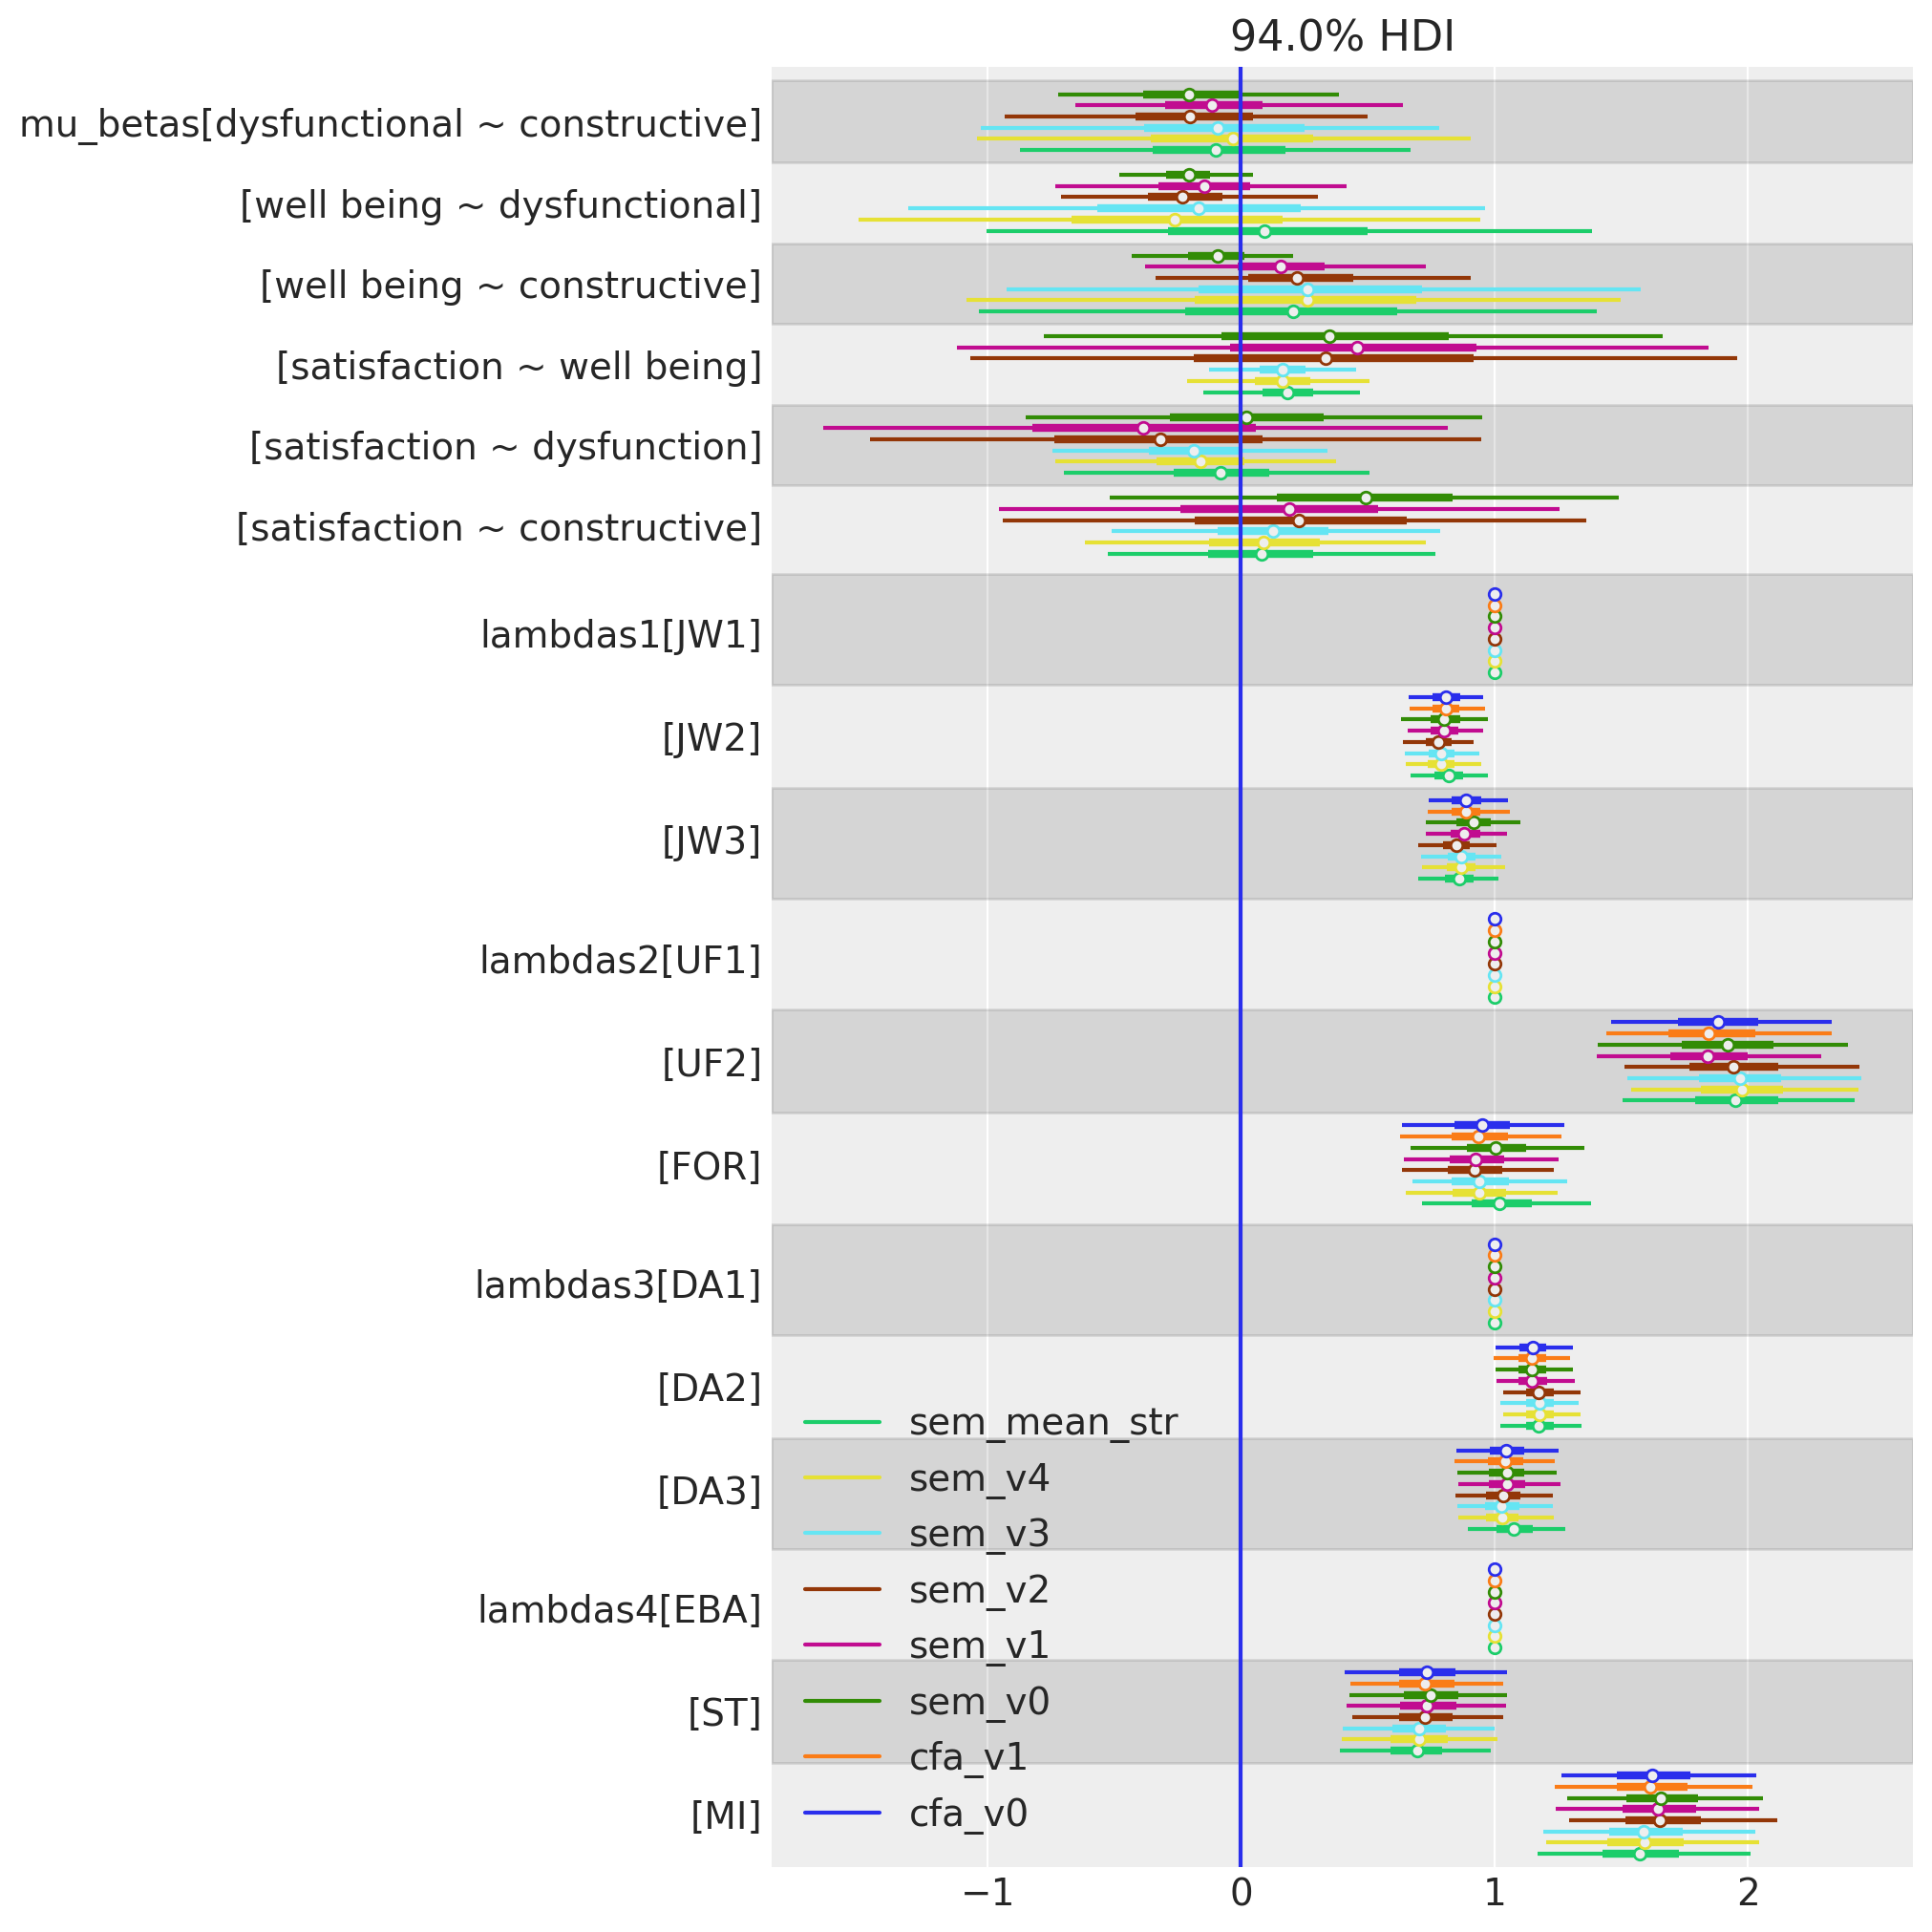

In [137]:
axs = az.plot_forest([idata_cfa_model_v0, idata_cfa_model_v1, idata_sem_model_v0,
                idata_sem_model_v1, idata_sem_model_v2, idata_sem_model_v3, idata_sem_model_v4, idata_sem_model_v5], 
                var_names=['mu_betas', 'lambdas1', 'lambdas2', 'lambdas3', 'lambdas4'], 
                model_names=['cfa_v0', 'cfa_v1', 'sem_v0', 'sem_v1', 'sem_v2', 'sem_v3', 'sem_v4', 'sem_mean_str'], combined=True, figsize=(10, 10))
axs[0].axvline(0)

In [138]:
compare_df = az.compare({
            'sem_v2': idata_sem_model_v2, 'sem_v3': idata_sem_model_v3, 
            'sem_v4': idata_sem_model_v4, 'sem_v5': idata_sem_model_v5 }, ic="loo")
compare_df

rank     elpd_loo       p_loo   elpd_diff        weight         se  \
sem_v3     0 -2879.591016  671.151027    0.000000  6.252702e-01  36.049651   
sem_v2     1 -2884.678000  680.954961    5.086984  3.747298e-01  35.544989   
sem_v4     2 -3166.752317   27.389470  287.161301  0.000000e+00  39.314937   
sem_v5     3 -3175.319011   39.201129  295.727996  3.778322e-11  39.129649   

              dse  warning scale  
sem_v3   0.000000     True   log  
sem_v2   6.896597     True   log  
sem_v4  10.500399    False   log  
sem_v5  10.780038    False   log

## Hierarchical SEM model



In [ ]:
grp_idx = np.random.binomial(1, .5, mean_shift_data.shape[0])
hierarchical_data = mean_shift_data.copy()
hierarchical_data[np.ix_(grp_idx == 1, [4, 8, 10])] += 3
hierarchical_data.mean(axis=0) 

array([-0.08907739,  2.92970172, -0.13077705, -0.01789775,  1.52800007,
        2.9939435 ,  0.03394001,  0.05163229,  4.58023591, -0.0248231 ,
        1.49111071, -0.06302011])

In [150]:
coords['group'] = ['man', 'woman']
coords.keys()

dict_keys(['obs', 'indicators', 'indicators_1', 'indicators_2', 'indicators_3', 'indicators_4', 'latent', 'latent1', 'paths', 'sd_params', 'corr_params', 'group'])

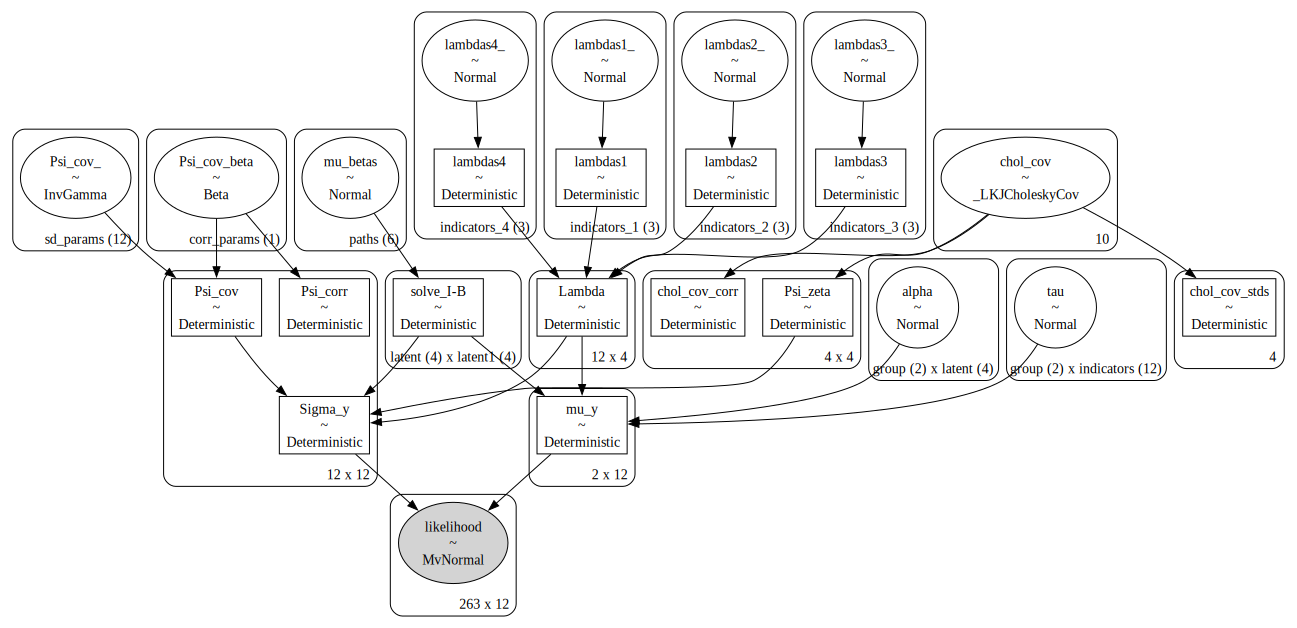

In [154]:
with pm.Model(coords=coords) as sem_model_hierarchical:
    
    # --- Factor loadings ---
    lambdas_1 = make_lambda('indicators_1', 'lambdas1', priors=[1, .5])
    lambdas_2 = make_lambda('indicators_2', 'lambdas2', priors=[1, .5])
    lambdas_3 = make_lambda('indicators_3', 'lambdas3', priors=[1, .5])
    lambdas_4 = make_lambda('indicators_4', 'lambdas4', priors=[1, .5])

    Lambda = pt.zeros((12, 4))
    Lambda = pt.set_subtensor(Lambda[0:3, 0], lambdas_1)
    Lambda = pt.set_subtensor(Lambda[3:6, 1], lambdas_2)
    Lambda = pt.set_subtensor(Lambda[6:9, 2], lambdas_3)
    Lambda = pt.set_subtensor(Lambda[9:12, 3], lambdas_4)
    Lambda = pm.Deterministic('Lambda', Lambda)

    sd_dist = pm.Exponential.dist(1.0, shape=4)
    chol, _, _ = pm.LKJCholeskyCov("chol_cov", n=4, eta=2, sd_dist=sd_dist, compute_corr=True)

    Psi_zeta = pm.Deterministic("Psi_zeta", chol.dot(chol.T))
    Psi = make_Psi('indicators')

    B = make_B()
    latent_dim = len(coords['latent'])
    I = pt.eye(latent_dim)
    lhs = I - B + 1e-8 * pt.eye(latent_dim)  # (latent_dim, latent_dim)
    inv_lhs = pm.Deterministic('solve_I-B', pt.slinalg.solve(lhs, pt.eye(latent_dim)), dims=('latent', 'latent1'))

    # Mean Structure
    tau = pm.Normal("tau", mu=0, sigma=0.5, dims=('group', 'indicators'))   # observed intercepts 
    alpha = pm.Normal("alpha", mu=0, sigma=0.5, dims=('group', 'latent'))       # latent means
    M = Lambda.dot(inv_lhs) 
    mu_latent = alpha.dot(M.T)
    mu_y = pm.Deterministic("mu_y", tau + mu_latent)

    Sigma_y = pm.Deterministic('Sigma_y', Lambda.dot(inv_lhs).dot(Psi_zeta).dot(inv_lhs.T).dot(Lambda.T) + Psi)
    _ = pm.MvNormal("likelihood", mu=mu_y[grp_idx], cov=Sigma_y, observed=hierarchical_data)

pm.model_to_graphviz(sem_model_hierarchical)


In [155]:
idata_sem_model_v6 = sample_model(sem_model_hierarchical, sampler_kwargs)

Sampling: [Psi_cov_, Psi_cov_beta, alpha, chol_cov, lambdas1_, lambdas2_, lambdas3_, lambdas4_, likelihood, mu_betas, tau]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambdas1_, lambdas2_, lambdas3_, lambdas4_, chol_cov, Psi_cov_, Psi_cov_beta, mu_betas, tau, alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 145 seconds.
Sampling: [likelihood]


Output()

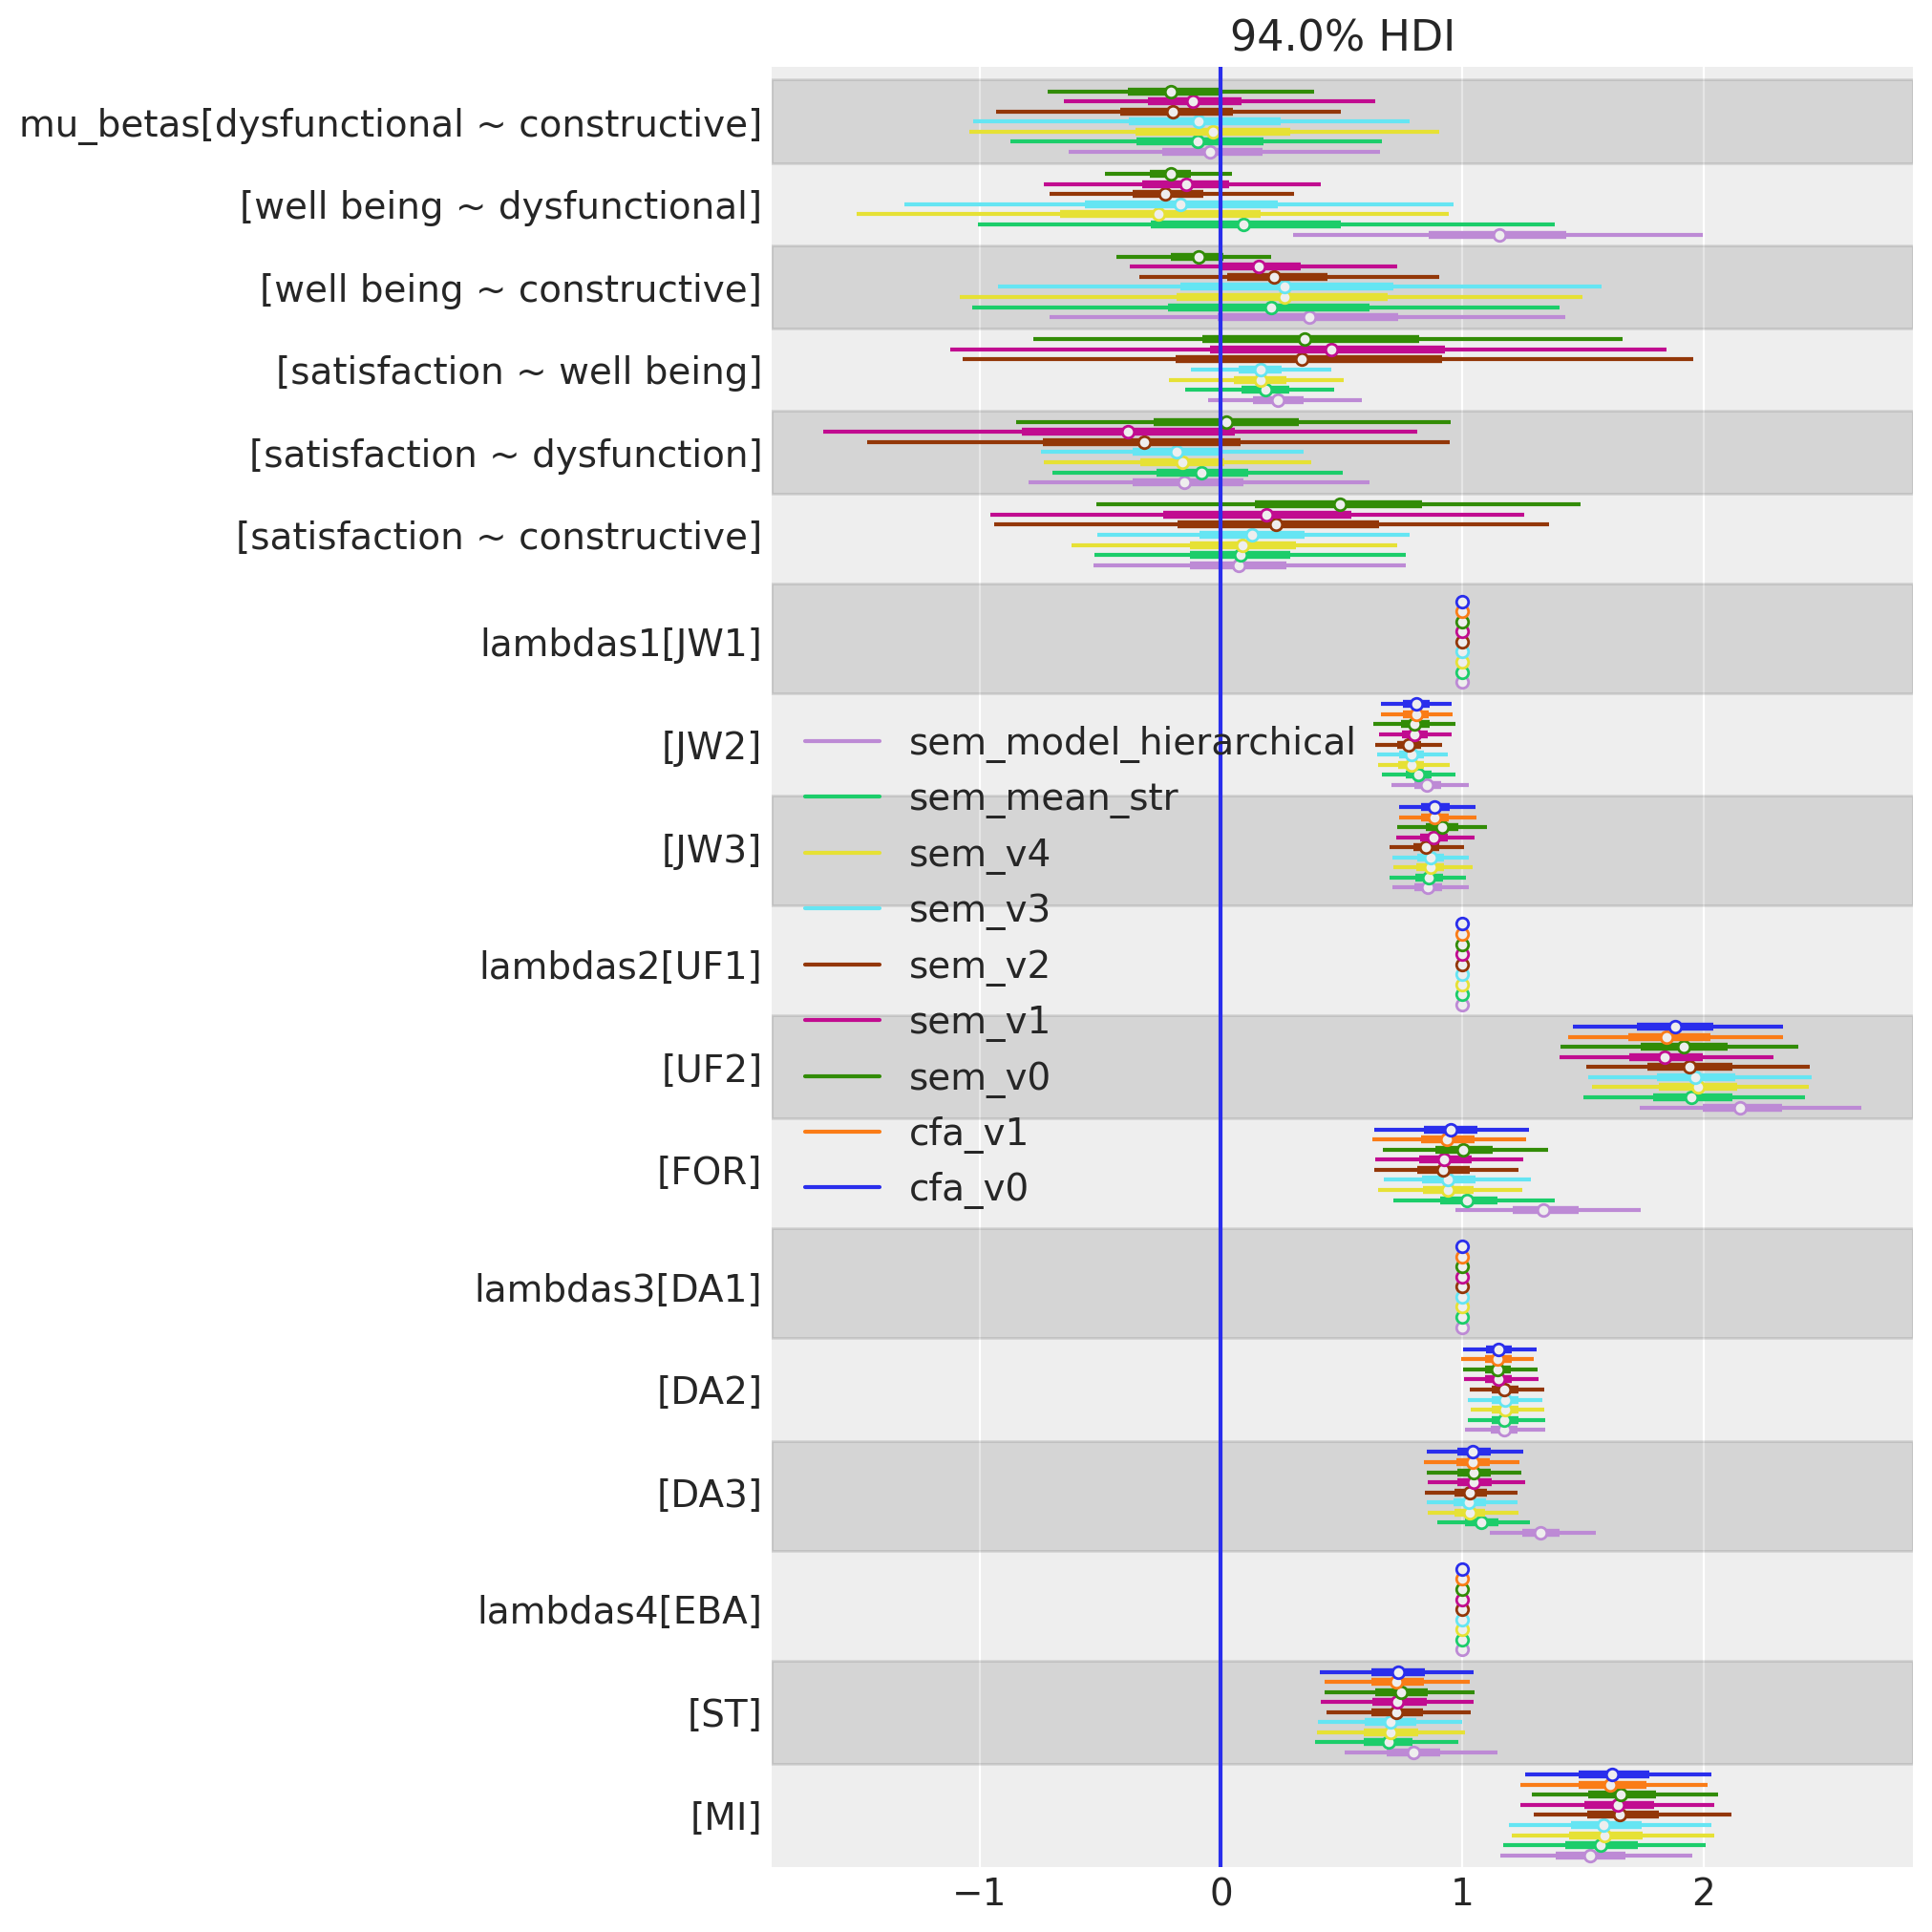

In [156]:
axs = az.plot_forest([idata_cfa_model_v0, idata_cfa_model_v1, idata_sem_model_v0,
                idata_sem_model_v1, idata_sem_model_v2, idata_sem_model_v3, idata_sem_model_v4, idata_sem_model_v5, idata_sem_model_v6], 
                var_names=['mu_betas', 'lambdas1', 'lambdas2', 'lambdas3', 'lambdas4'], 
                model_names=['cfa_v0', 'cfa_v1', 'sem_v0', 'sem_v1', 'sem_v2', 'sem_v3', 'sem_v4', 'sem_mean_str', 
                             'sem_model_hierarchical'], combined=True, figsize=(10, 10))
axs[0].axvline(0)

In [157]:
az.summary(idata_sem_model_v6, var_names=['tau'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau[man, JW1]   -0.671  0.273  -1.156   -0.125      0.006    0.004    2415.0   
tau[man, JW2]    2.259  0.244   1.837    2.753      0.005    0.003    2485.0   
tau[man, JW3]   -0.687  0.240  -1.140   -0.238      0.005    0.003    2482.0   
tau[man, UF1]   -0.512  0.170  -0.820   -0.180      0.003    0.002    2937.0   
tau[man, UF2]   -1.060  0.346  -1.727   -0.443      0.006    0.004    3009.0   
tau[man, FOR]    2.208  0.251   1.725    2.651      0.005    0.004    2482.0   
tau[man, DA1]   -0.851  0.235  -1.299   -0.421      0.004    0.003    3453.0   
tau[man, DA2]   -1.010  0.275  -1.524   -0.492      0.005    0.003    3399.0   
tau[man, DA3]    1.804  0.324   1.191    2.408      0.006    0.004    3348.0   
tau[man, EBA]   -0.009  0.235  -0.451    0.426      0.004    0.003    3764.0   
tau[man, ST]    -0.068  0.203  -0.425    0.330      0.003    0.003    3720.0   
tau[man, MI]    -0.103  0.355  -0.763    0.557      0.006    0.005    3738.0   
tau[woman, JW1] -0.857  0.269  -1.342   -0.349      0.006    0.004    2280.0   
tau[woman, JW2]  2.363  0.251   1.894    2.814      0.005    0.004    2166.0   
tau[woman, JW3] -0.726  0.240  -1.146   -0.261      0.005    0.004    2194.0   
tau[woman, UF1] -1.338  0.187  -1.701   -1.000      0.003    0.002    3678.0   
tau[woman, UF2]  0.181  0.382  -0.576    0.857      0.006    0.005    4268.0   
tau[woman, FOR]  1.291  0.320   0.717    1.882      0.006    0.004    2961.0   
tau[woman, DA1] -1.815  0.255  -2.312   -1.361      0.004    0.003    3851.0   
tau[woman, DA2] -2.104  0.294  -2.657   -1.564      0.005    0.003    3804.0   
tau[woman, DA3]  3.645  0.388   2.920    4.380      0.007    0.005    3570.0   
tau[woman, EBA] -0.578  0.272  -1.056   -0.041      0.005    0.003    3452.0   
tau[woman, ST]   2.516  0.259   2.008    2.960      0.004    0.003    3363.0   
tau[woman, MI]  -0.832  0.400  -1.552   -0.060      0.007    0.005    3446.0   

                 ess_tail  r_hat  
tau[man, JW1]      2640.0    1.0  
tau[man, JW2]      2677.0    1.0  
tau[man, JW3]      2422.0    1.0  
tau[man, UF1]      3036.0    1.0  
tau[man, UF2]      2996.0    1.0  
tau[man, FOR]      2587.0    1.0  
tau[man, DA1]      2871.0    1.0  
tau[man, DA2]      2456.0    1.0  
tau[man, DA3]      2692.0    1.0  
tau[man, EBA]      3262.0    1.0  
tau[man, ST]       3271.0    1.0  
tau[man, MI]       3082.0    1.0  
tau[woman, JW1]    2919.0    1.0  
tau[woman, JW2]    2904.0    1.0  
tau[woman, JW3]    2731.0    1.0  
tau[woman, UF1]    2832.0    1.0  
tau[woman, UF2]    3038.0    1.0  
tau[woman, FOR]    2386.0    1.0  
tau[woman, DA1]    2770.0    1.0  
tau[woman, DA2]    2985.0    1.0  
tau[woman, DA3]    3158.0    1.0  
tau[woman, EBA]    3193.0    1.0  
tau[woman, ST]     2989.0    1.0  
tau[woman, MI]     3344.0    1.0

In [158]:
az.summary(idata_sem_model_v6, var_names=['alpha'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
alpha[man, satisfaction]     0.614  0.273   0.107    1.137      0.006   
alpha[man, well being]       0.372  0.202  -0.028    0.739      0.004   
alpha[man, dysfunctional]    0.316  0.312  -0.263    0.888      0.005   
alpha[man, constructive]    -0.231  0.313  -0.797    0.383      0.005   
alpha[woman, satisfaction]   0.728  0.270   0.234    1.229      0.006   
alpha[woman, well being]     1.106  0.225   0.681    1.524      0.004   
alpha[woman, dysfunctional]  0.467  0.449  -0.384    1.326      0.006   
alpha[woman, constructive]   0.119  0.454  -0.701    0.994      0.005   

                             mcse_sd  ess_bulk  ess_tail  r_hat  
alpha[man, satisfaction]       0.004    2404.0    2540.0    1.0  
alpha[man, well being]         0.003    2252.0    2024.0    1.0  
alpha[man, dysfunctional]      0.004    3353.0    2703.0    1.0  
alpha[man, constructive]       0.004    4004.0    2805.0    1.0  
alpha[woman, satisfaction]     0.004    2247.0    3016.0    1.0  
alpha[woman, well being]       0.003    2726.0    2327.0    1.0  
alpha[woman, dysfunctional]    0.005    4833.0    3181.0    1.0  
alpha[woman, constructive]     0.007    7152.0    2835.0    1.0

In [159]:
compare_df = az.compare({
            'sem_v2': idata_sem_model_v2, 'sem_v3': idata_sem_model_v3, 
            'sem_v4': idata_sem_model_v4, 'sem_v5': idata_sem_model_v5, 
             'sem_v6': idata_sem_model_v6 }, ic="loo")
compare_df

rank     elpd_loo       p_loo   elpd_diff        weight         se  \
sem_v3     0 -2879.591016  671.151027    0.000000  6.252702e-01  36.049651   
sem_v2     1 -2884.678000  680.954961    5.086984  3.747298e-01  35.544989   
sem_v4     2 -3166.752317   27.389470  287.161301  0.000000e+00  39.314937   
sem_v5     3 -3175.319011   39.201129  295.727996  0.000000e+00  39.129649   
sem_v6     4 -3184.104142   50.737144  304.513126  2.200973e-11  38.701198   

              dse  warning scale  
sem_v3   0.000000     True   log  
sem_v2   6.896597     True   log  
sem_v4  10.500399    False   log  
sem_v5  10.780038    False   log  
sem_v6  12.770773    False   log

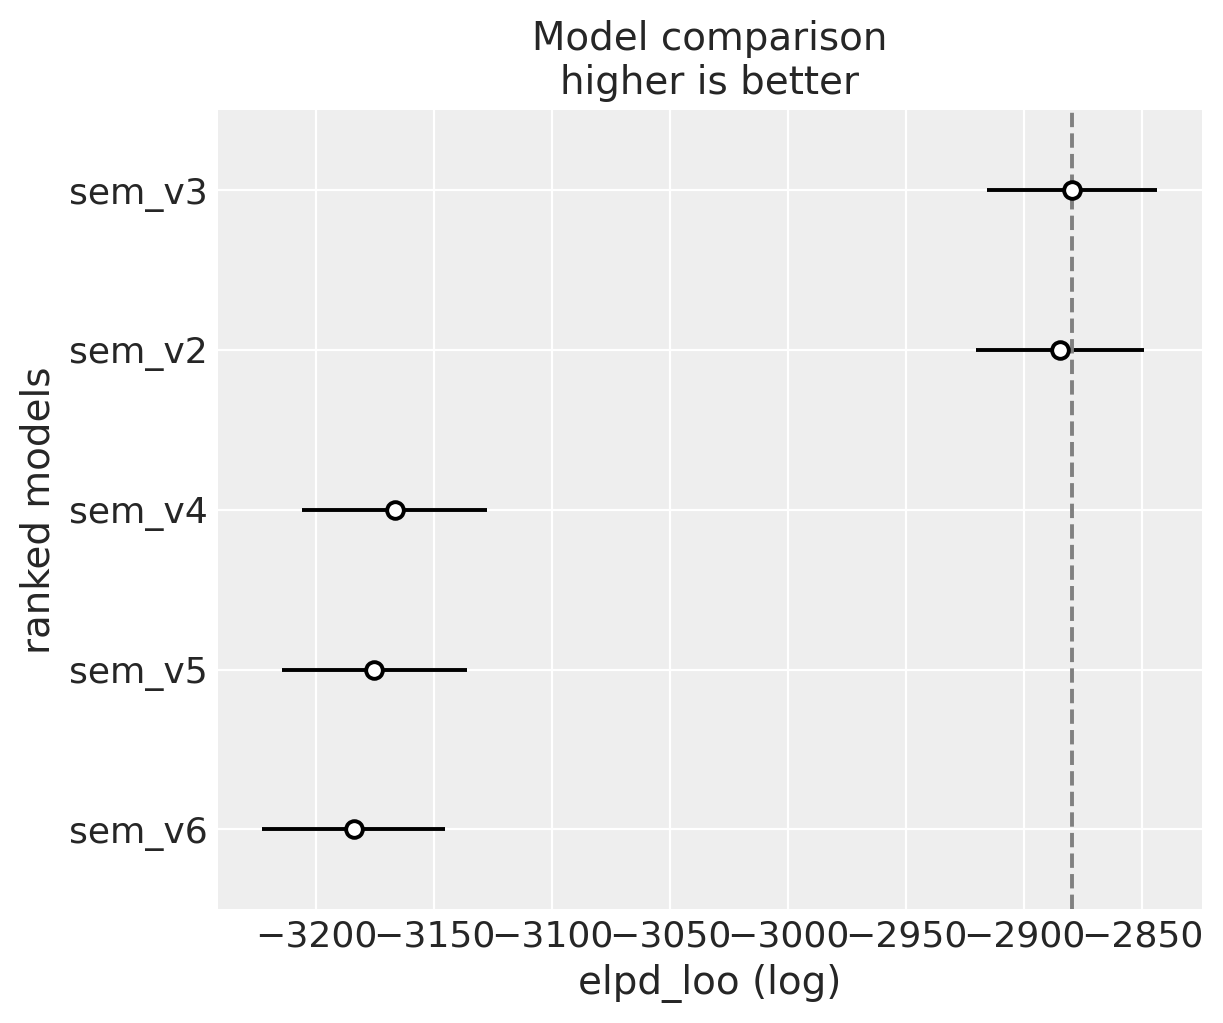

In [161]:
az.plot_compare(compare_df);

## Hierarchical Model on Structural Components

In [166]:
coords['group'] = ['man', 'woman']
coords.keys()

dict_keys(['obs', 'indicators', 'indicators_1', 'indicators_2', 'indicators_3', 'indicators_4', 'latent', 'latent1', 'paths', 'sd_params', 'corr_params', 'group'])

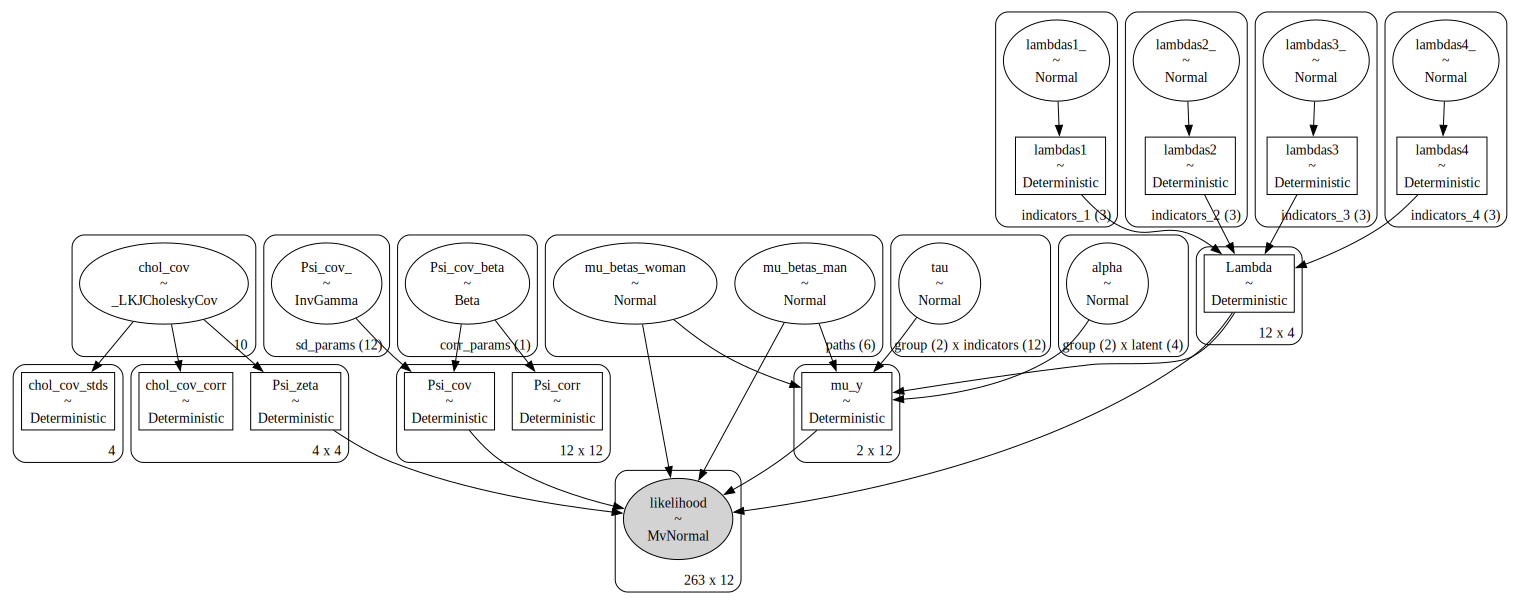

In [ ]:
with pm.Model(coords=coords) as sem_model_hierarchical2:
    
    # --- Factor loadings ---
    lambdas_1 = make_lambda('indicators_1', 'lambdas1', priors=[1, .5])
    lambdas_2 = make_lambda('indicators_2', 'lambdas2', priors=[1, .5])
    lambdas_3 = make_lambda('indicators_3', 'lambdas3', priors=[1, .5])
    lambdas_4 = make_lambda('indicators_4', 'lambdas4', priors=[1, .5])

    Lambda = pt.zeros((12, 4))
    Lambda = pt.set_subtensor(Lambda[0:3, 0], lambdas_1)
    Lambda = pt.set_subtensor(Lambda[3:6, 1], lambdas_2)
    Lambda = pt.set_subtensor(Lambda[6:9, 2], lambdas_3)
    Lambda = pt.set_subtensor(Lambda[9:12, 3], lambdas_4)
    Lambda = pm.Deterministic('Lambda', Lambda)

    sd_dist = pm.Exponential.dist(1.0, shape=4)
    chol, _, _ = pm.LKJCholeskyCov("chol_cov", n=4, eta=2, sd_dist=sd_dist, compute_corr=True)

    Psi_zeta = pm.Deterministic("Psi_zeta", chol.dot(chol.T))
    Psi = make_Psi('indicators')

    Bs = []
    for g in coords["group"]:
        B_g = make_B(group_suffix=f"_{g}")  # give group-specific names
        Bs.append(B_g)
    B_ = pt.stack(Bs)

    latent_dim = len(coords['latent'])
    I = pt.eye(latent_dim)

    # invert (I - B_g) for each group
    inv_I_minus_B = pt.stack([
        pt.slinalg.solve(I - B_[g] + 1e-8 * I, I)
        for g in range(len(coords["group"]))
    ])

    # Mean Structure
    tau = pm.Normal("tau", mu=0, sigma=0.5, dims=('group', 'indicators'))   # observed intercepts 
    alpha = pm.Normal("alpha", mu=0, sigma=0.5, dims=('group', 'latent'))       # latent means
    M = pt.matmul(Lambda, inv_I_minus_B)  
    mu_latent = pt.matmul(alpha[:, None, :], M.transpose(0, 2, 1))[:,:,0]
    mu_y = pm.Deterministic("mu_y", tau + mu_latent)

    Sigma_y = []
    for g in range(len(coords['group'])):
        inv_lhs = inv_I_minus_B[g]
        Sigma_y_g = Lambda @ inv_lhs @ Psi_zeta @ inv_lhs.T @ Lambda.T + Psi
        Sigma_y.append(Sigma_y_g)
    Sigma_y = pt.stack(Sigma_y)
    _ = pm.MvNormal("likelihood", mu=mu_y[grp_idx], cov=Sigma_y[grp_idx], observed=hierarchical_data)

pm.model_to_graphviz(sem_model_hierarchical2)

In [185]:
idata_sem_model_v7 = sample_model(sem_model_hierarchical2, sampler_kwargs)

Sampling: [Psi_cov_, Psi_cov_beta, alpha, chol_cov, lambdas1_, lambdas2_, lambdas3_, lambdas4_, likelihood, mu_betas_man, mu_betas_woman, tau]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambdas1_, lambdas2_, lambdas3_, lambdas4_, chol_cov, Psi_cov_, Psi_cov_beta, mu_betas_man, mu_betas_woman, tau, alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2048 seconds.
Sampling: [likelihood]


Output()

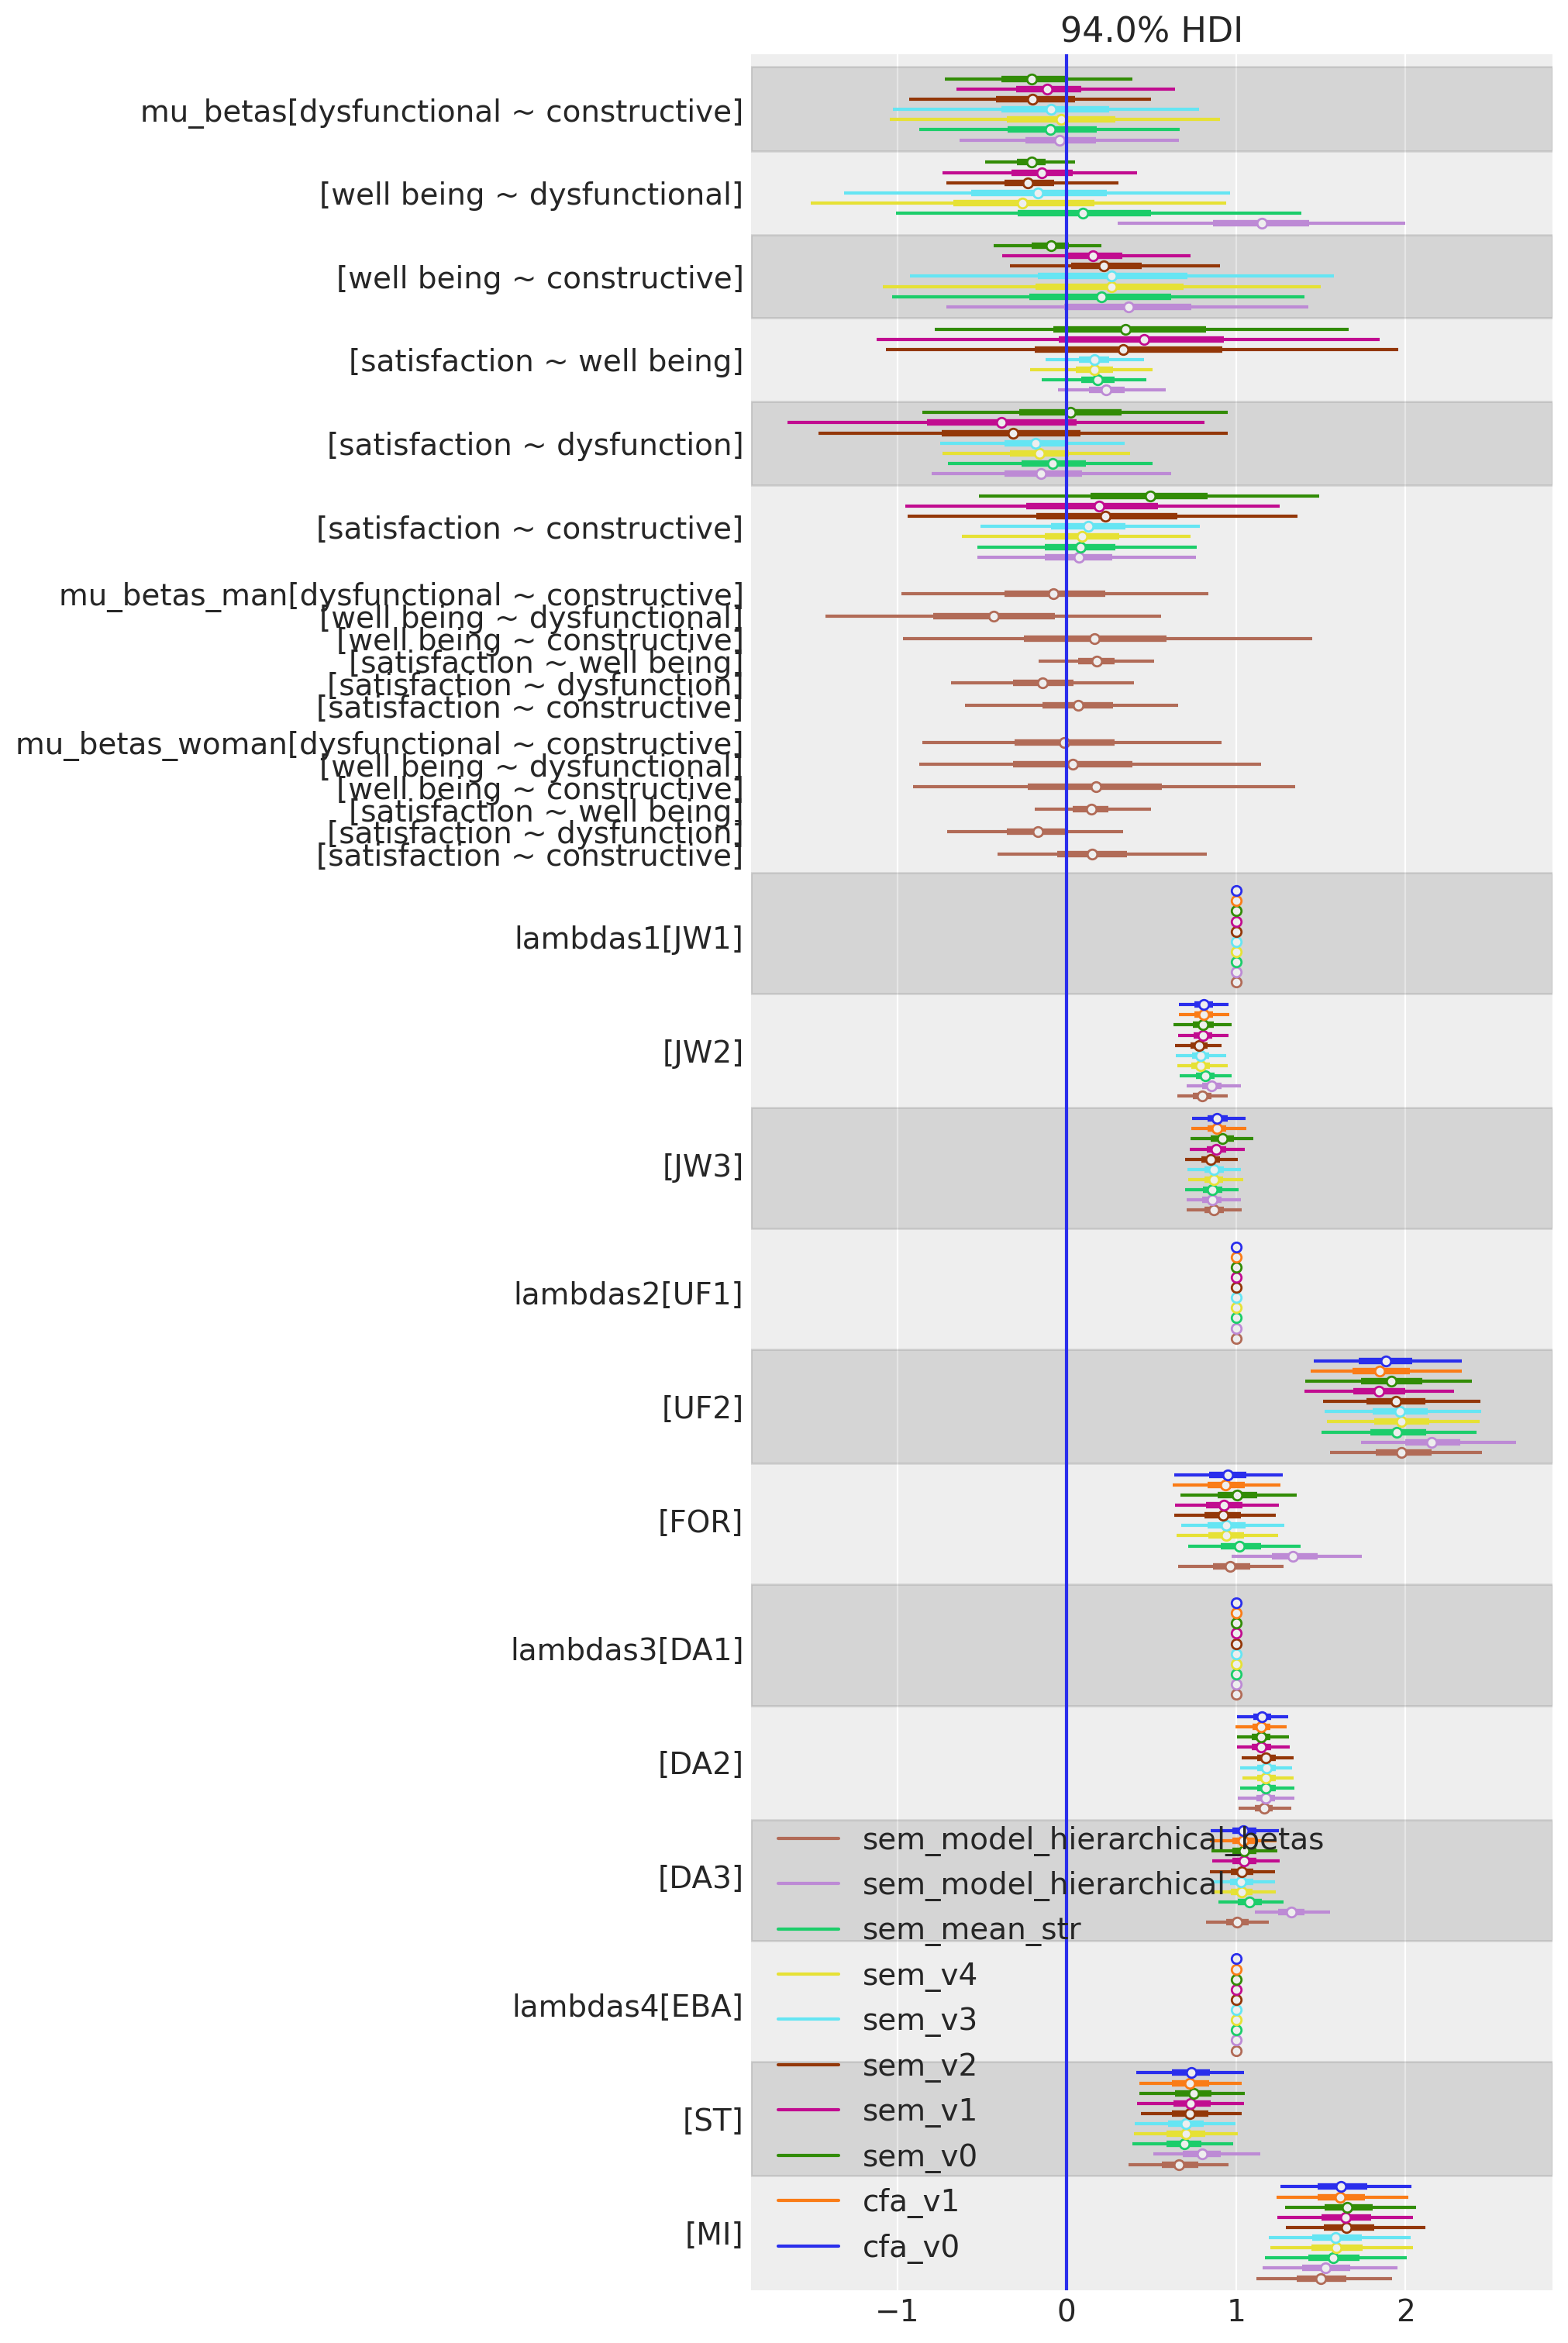

In [188]:
axs = az.plot_forest([idata_cfa_model_v0, idata_cfa_model_v1, idata_sem_model_v0,
                idata_sem_model_v1, idata_sem_model_v2, idata_sem_model_v3, idata_sem_model_v4, idata_sem_model_v5, 
                idata_sem_model_v6, idata_sem_model_v7], 
                var_names=['mu_betas', 'mu_betas_man', 'mu_betas_woman', 'lambdas1', 'lambdas2', 'lambdas3', 'lambdas4'], 
                model_names=['cfa_v0', 'cfa_v1', 'sem_v0', 'sem_v1', 'sem_v2', 'sem_v3', 'sem_v4', 'sem_mean_str', 
                             'sem_model_hierarchical', 'sem_model_hierarchical_betas'], combined=True, figsize=(10, 15))
axs[0].axvline(0)

In [192]:
az.summary(idata_sem_model_v7, var_names=['mu_betas_man', 'mu_betas_woman'])

mean     sd  hdi_3%  hdi_97%  \
mu_betas_man[dysfunctional ~ constructive]   -0.074  0.470  -0.974    0.835   
mu_betas_man[well being ~ dysfunctional]     -0.435  0.534  -1.426    0.558   
mu_betas_man[well being ~ constructive]       0.173  0.631  -0.965    1.451   
mu_betas_man[satisfaction ~ well being]       0.174  0.180  -0.166    0.515   
mu_betas_man[satisfaction ~ dysfunction]     -0.138  0.285  -0.682    0.398   
mu_betas_man[satisfaction ~ constructive]     0.063  0.333  -0.600    0.656   
mu_betas_woman[dysfunctional ~ constructive] -0.011  0.466  -0.854    0.914   
mu_betas_woman[well being ~ dysfunctional]    0.042  0.534  -0.871    1.146   
mu_betas_woman[well being ~ constructive]     0.168  0.603  -0.908    1.347   
mu_betas_woman[satisfaction ~ well being]     0.141  0.180  -0.191    0.496   
mu_betas_woman[satisfaction ~ dysfunction]   -0.174  0.279  -0.704    0.335   
mu_betas_woman[satisfaction ~ constructive]   0.149  0.327  -0.410    0.827   

                                              mcse_mean  mcse_sd  ess_bulk  \
mu_betas_man[dysfunctional ~ constructive]        0.011    0.008    2021.0   
mu_betas_man[well being ~ dysfunctional]          0.011    0.008    2268.0   
mu_betas_man[well being ~ constructive]           0.013    0.010    2350.0   
mu_betas_man[satisfaction ~ well being]           0.004    0.003    2277.0   
mu_betas_man[satisfaction ~ dysfunction]          0.006    0.006    2728.0   
mu_betas_man[satisfaction ~ constructive]         0.007    0.006    2481.0   
mu_betas_woman[dysfunctional ~ constructive]      0.010    0.009    2159.0   
mu_betas_woman[well being ~ dysfunctional]        0.011    0.008    2328.0   
mu_betas_woman[well being ~ constructive]         0.013    0.009    2321.0   
mu_betas_woman[satisfaction ~ well being]         0.004    0.003    2318.0   
mu_betas_woman[satisfaction ~ dysfunction]        0.005    0.005    2728.0   
mu_betas_woman[satisfaction ~ constructive]       0.007    0.006    2552.0   

                                              ess_tail  r_hat  
mu_betas_man[dysfunctional ~ constructive]      2063.0    1.0  
mu_betas_man[well being ~ dysfunctional]        2449.0    1.0  
mu_betas_man[well being ~ constructive]         2697.0    1.0  
mu_betas_man[satisfaction ~ well being]         1814.0    1.0  
mu_betas_man[satisfaction ~ dysfunction]        1926.0    1.0  
mu_betas_man[satisfaction ~ constructive]       2147.0    1.0  
mu_betas_woman[dysfunctional ~ constructive]    2188.0    1.0  
mu_betas_woman[well being ~ dysfunctional]      2352.0    1.0  
mu_betas_woman[well being ~ constructive]       2245.0    1.0  
mu_betas_woman[satisfaction ~ well being]       1882.0    1.0  
mu_betas_woman[satisfaction ~ dysfunction]      1897.0    1.0  
mu_betas_woman[satisfaction ~ constructive]     2361.0    1.0

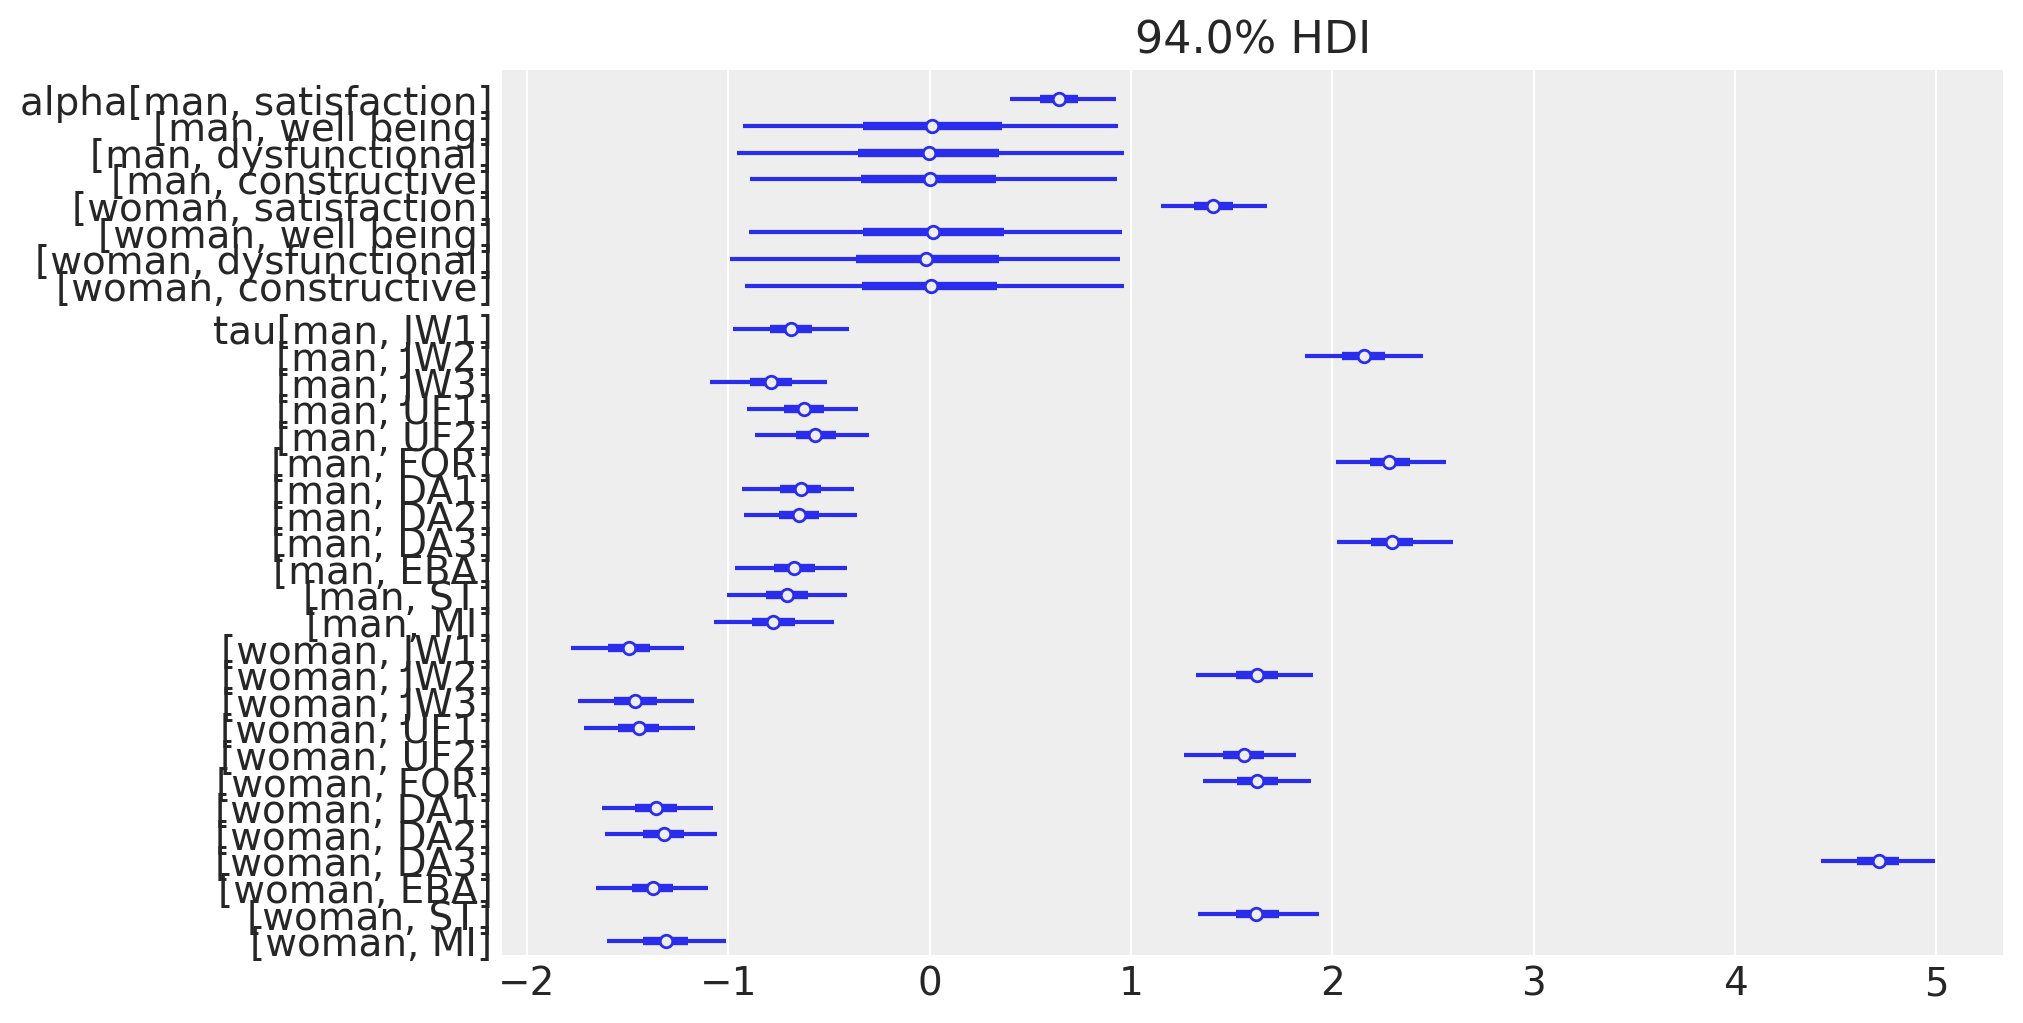

In [197]:
az.plot_forest(idata_sem_model_v7, var_names=['alpha', 'tau'], combined=True, figsize=(10, 5));

In [203]:
az.summary(idata_sem_model_v7, var_names=['mu_betas_man'])[['mean']].values - az.summary(idata_sem_model_v7, var_names=['mu_betas_woman'])[['mean']].values

array([[-0.063],
       [-0.477],
       [ 0.005],
       [ 0.033],
       [ 0.036],
       [-0.086]])

In [204]:
compare_df = az.compare({
            'sem_v2': idata_sem_model_v2, 'sem_v3': idata_sem_model_v3, 
            'sem_v4': idata_sem_model_v4, 'sem_v5': idata_sem_model_v5, 
             'sem_v6': idata_sem_model_v6, 'sem_v7': idata_sem_model_v7 }, ic="loo")
compare_df

rank     elpd_loo       p_loo   elpd_diff        weight         se  \
sem_v3     0 -2879.591016  671.151027    0.000000  6.252702e-01  36.049651   
sem_v2     1 -2884.678000  680.954961    5.086984  3.747298e-01  35.544989   
sem_v4     2 -3166.752317   27.389470  287.161301  0.000000e+00  39.314937   
sem_v5     3 -3175.319011   39.201129  295.727996  0.000000e+00  39.129649   
sem_v7     4 -3178.597954   55.642378  299.006939  0.000000e+00  39.142705   
sem_v6     5 -3184.104142   50.737144  304.513126  1.151590e-11  38.701198   

              dse  warning scale  
sem_v3   0.000000     True   log  
sem_v2   6.896597     True   log  
sem_v4  10.500399    False   log  
sem_v5  10.780038    False   log  
sem_v7  11.768149    False   log  
sem_v6  12.770773    False   log

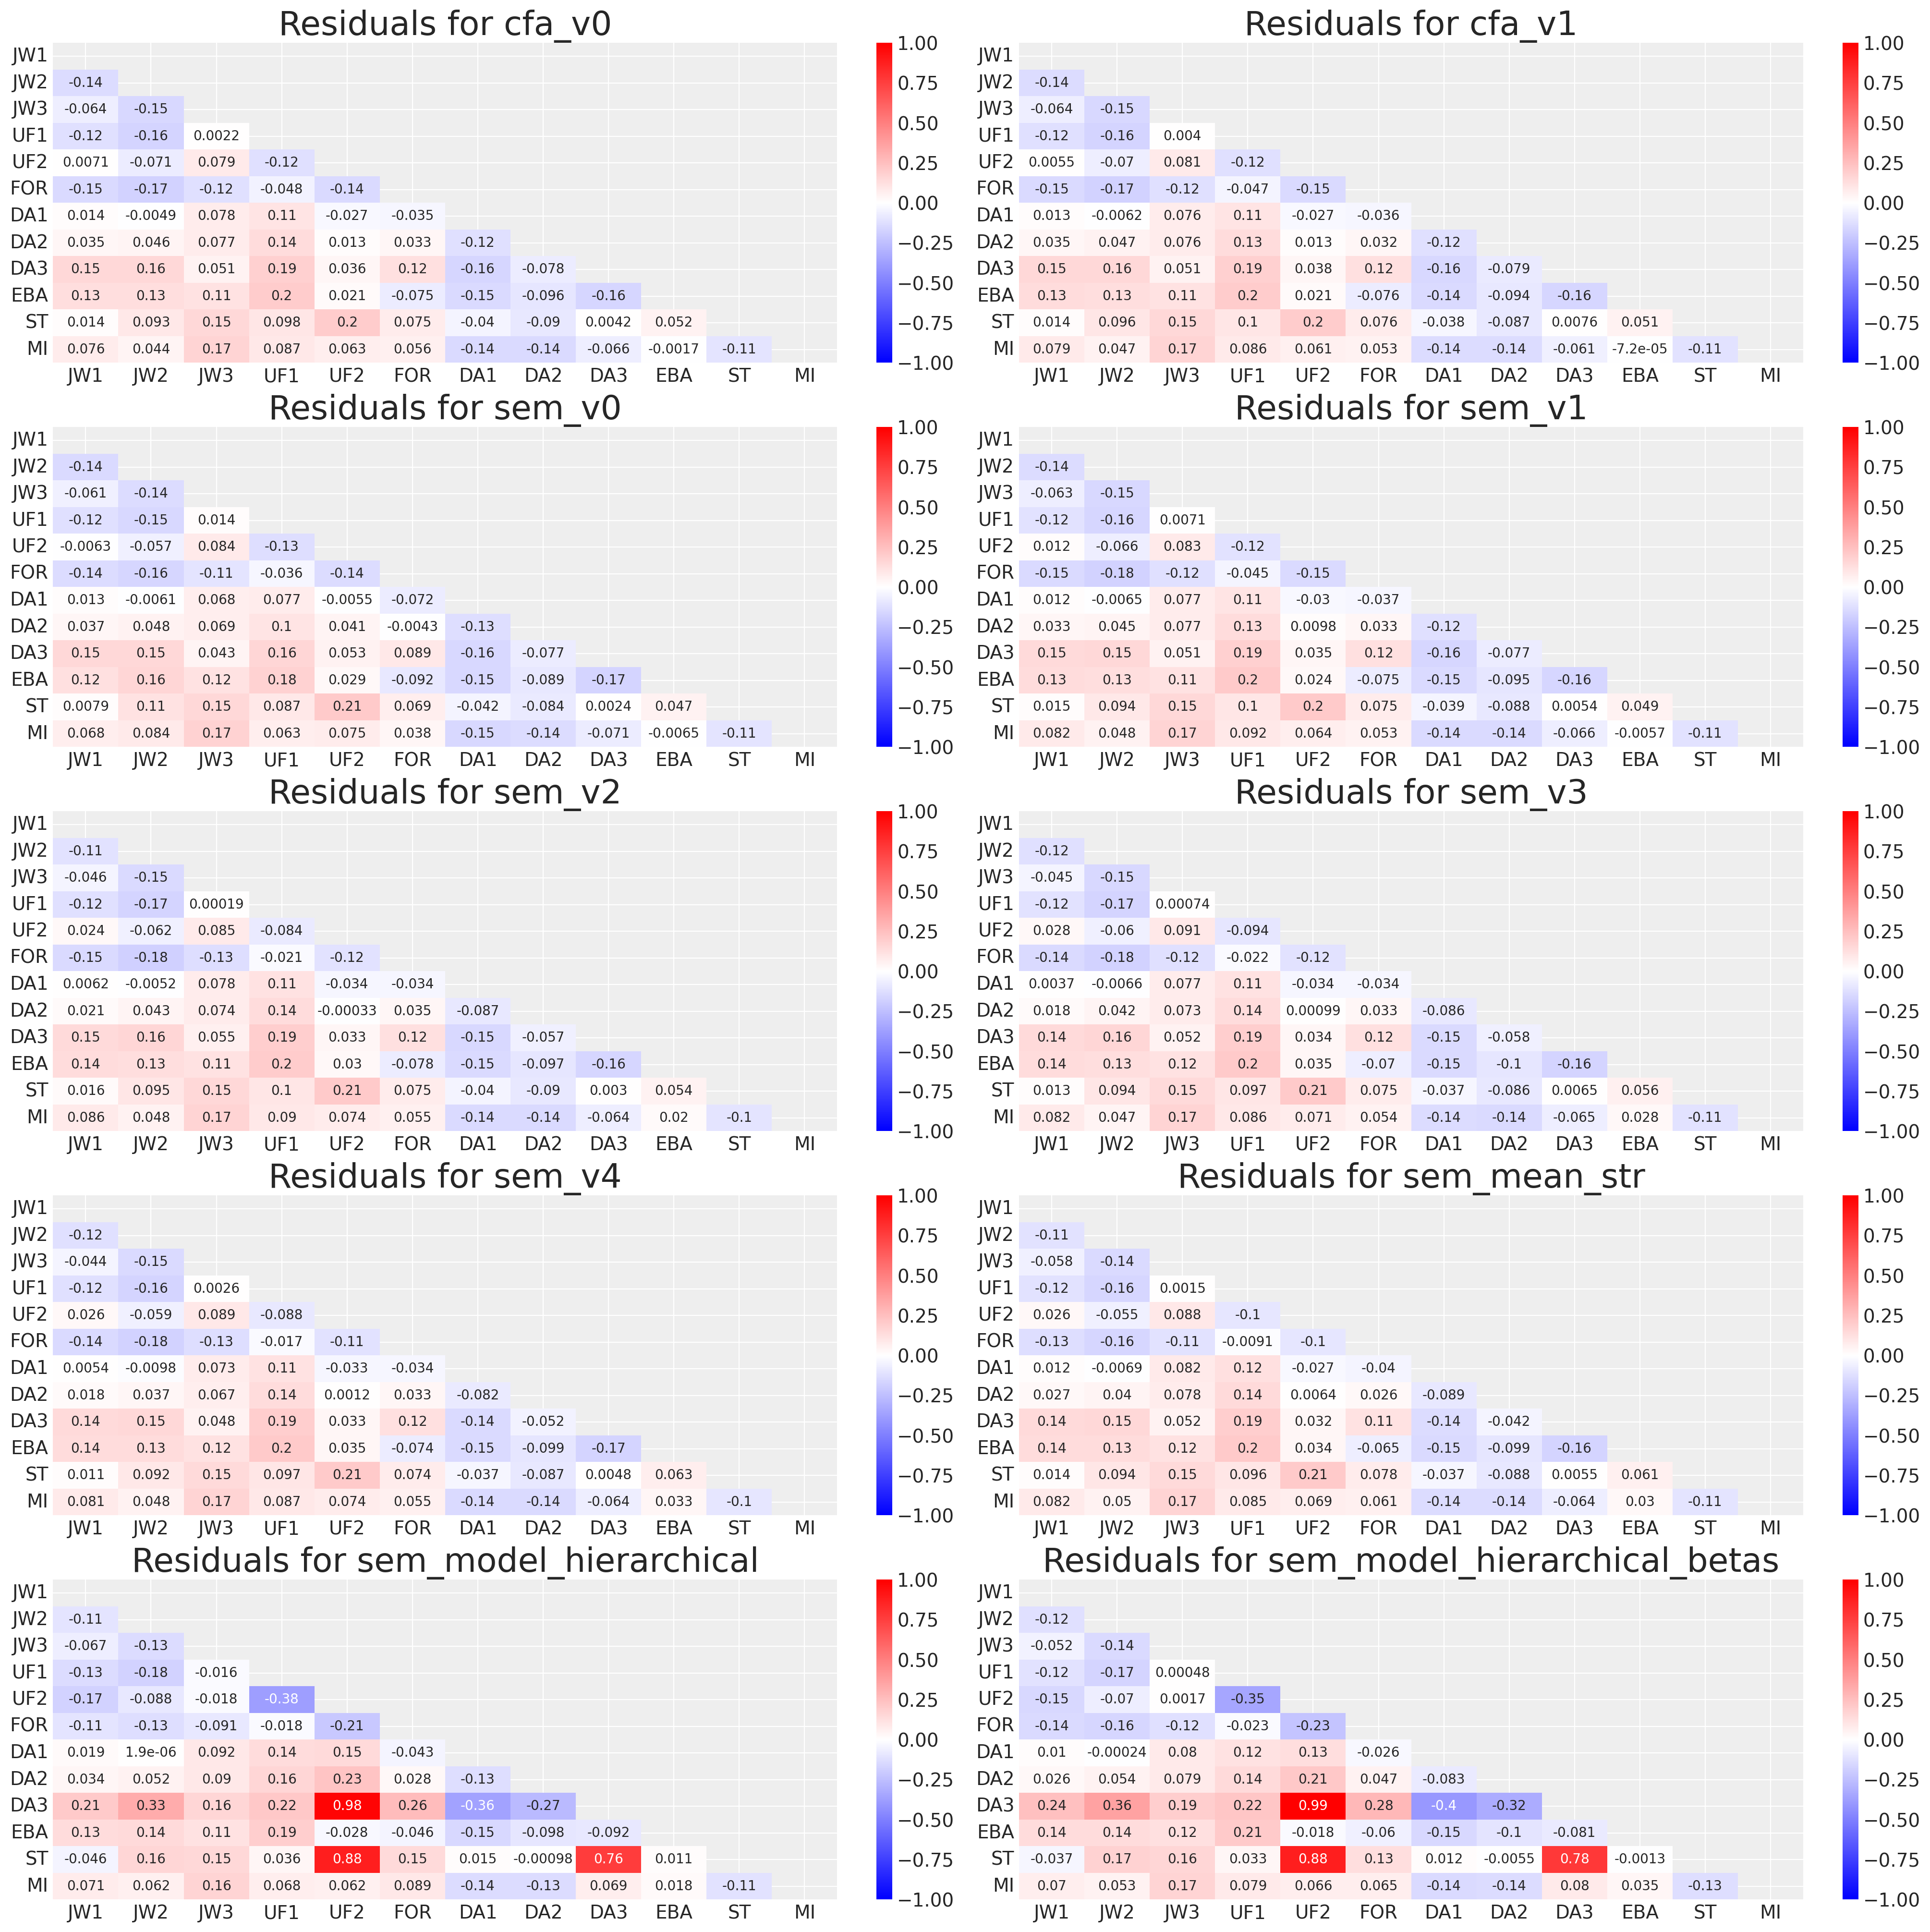

In [212]:
def get_posterior_resids(idata, samples=100, metric="cov"):
    resids = []
    for i in range(samples):
        if metric == "cov":
            model_cov = pd.DataFrame(
                az.extract(idata["posterior_predictive"])["likelihood"][:, :, i]
            ).cov()
            obs_cov = sample_df[FEATURE_COLUMNS].cov()
        else:
            model_cov = pd.DataFrame(
                az.extract(idata["posterior_predictive"])["likelihood"][:, :, i]
            ).corr()
            obs_cov = sample_df[FEATURE_COLUMNS].corr()
        model_cov.index = obs_cov.index
        model_cov.columns = obs_cov.columns
        residuals = model_cov - obs_cov
        resids.append(residuals.values.flatten())

    residuals_posterior = pd.DataFrame(pd.DataFrame(resids).mean().values.reshape(12, 12))
    residuals_posterior.index = obs_cov.index
    residuals_posterior.columns = obs_cov.index
    return residuals_posterior

import seaborn as sns

idatas = [idata_cfa_model_v0, idata_cfa_model_v1, idata_sem_model_v0, idata_sem_model_v1, 
          idata_sem_model_v2, idata_sem_model_v3, idata_sem_model_v4, idata_sem_model_v5, idata_sem_model_v6,
          idata_sem_model_v7]
model_names=['cfa_v0', 'cfa_v1', 'sem_v0', 'sem_v1', 'sem_v2', 'sem_v3', 'sem_v4', 'sem_mean_str', 
                             'sem_model_hierarchical', 'sem_model_hierarchical_betas']


fig, axs = plt.subplots(5, 2, figsize=(20, 20))
axs = axs.flatten()
for idata, model_name, ax in zip(idatas, model_names, axs):
    residuals_posterior_corr = get_posterior_resids(idata, 2500, metric="corr")
    mask = np.triu(np.ones_like(residuals_posterior_corr, dtype=bool))
    sns.heatmap(residuals_posterior_corr, annot=True, cmap="bwr", mask=mask, ax=ax, vmin=-1, vmax=1)
    ax.set_title(f"Residuals for {model_name}", fontsize=25);

## Authors
- Authored by [Nathaniel Forde](https://nathanielf.github.io/) in November 2025 

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [4]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Wed Dec 28 2022

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.7.0

pytensor: 2.8.11

pymc      : 5.0.1
numpy     : 1.24.0
arviz     : 0.14.0
pandas    : 1.5.2
sys       : 3.11.0 | packaged by conda-forge | (main, Oct 25 2022, 06:21:25) [Clang 14.0.4 ]
matplotlib: 3.6.2

Watermark: 2.3.1



:::{include} ../page_footer.md
:::